# Miscellaneous Scripts


CSV Scripts

In [ ]:
# JSON to CSV Script → Parsing data from linkedIn for further usage

import json
import pandas as pd
from google.colab import files

# 1. Upload your JSON file via Colab's UI
print("Please upload the JSON file when prompted.")
uploaded = files.upload()
if not uploaded:
    raise ValueError("No file uploaded. Please try again.")

# 2. Read the uploaded JSON content
filename = next(iter(uploaded))
print(f"Loaded file: {filename}")
content = uploaded[filename].decode('utf-8')

# 3. Parse JSON (standard or NDJSON)
try:
    data = json.loads(content)
except json.JSONDecodeError:
    lines = [line for line in content.splitlines() if line.strip()]
    data = [json.loads(line) for line in lines]

# 4. Drill down to your list of profile records
if isinstance(data, dict) and "profiles" in data and isinstance(data["profiles"], list):
    records = data["profiles"]
elif isinstance(data, dict):
    records = list(data.values())
elif isinstance(data, list):
    records = data
else:
    raise ValueError("Unexpected JSON structure")

rows = []
for entry in records:
    public_id = entry.get('public_identifier', '')
    # Add LinkedIn URL prefix to the identifier
    if public_id:
        public_id = f"https://www.linkedin.com/in/{public_id}"

    # ensure profile_data is a dict
    pdict = entry.get('profile_data') or {}
    if not isinstance(pdict, dict):
        pdict = {}

    # --- experiences: company, title, description ---
    exp_pieces = []
    for exp in pdict.get('experiences') or []:
        if not isinstance(exp, dict):
            continue
        comp  = (exp.get('company')       or '').strip()
        title = (exp.get('title')         or '').strip()
        desc  = (exp.get('description')   or '').strip()
        if comp or title or desc:
            exp_pieces.append(f"{comp} ({title}): {desc}")
    exp_str = " | ".join(exp_pieces)

    # --- certifications: authority, name ---
    cert_pieces = []
    for cert in pdict.get('certifications') or []:
        if not isinstance(cert, dict):
            continue
        auth = (cert.get('authority') or '').strip()
        name = (cert.get('name')      or '').strip()
        if auth or name:
            cert_pieces.append(f"{auth}: {name}")
    cert_str = " | ".join(cert_pieces)

    # --- education: field_of_study, degree_name, school ---
    edu_pieces = []
    for edu in pdict.get('education') or []:
        if not isinstance(edu, dict):
            continue
        field  = (edu.get('field_of_study') or '').strip()
        degree = (edu.get('degree_name')    or '').strip()
        school = (edu.get('school')         or '').strip()
        if field or degree or school:
            edu_pieces.append(f"{field} – {degree} @ {school}")
    edu_str = " | ".join(edu_pieces)

    # --- summary: raw string ---
    summary_str = (pdict.get('summary') or '').strip()

    # combine into one column
    profile_summary = " || ".join([
        f"Experiences: {exp_str}",
        f"Certifications: {cert_str}",
        f"Education: {edu_str}",
        f"Summary: {summary_str}"
    ])

    rows.append({
        'public_identifier': public_id,
        'profile_summary': profile_summary
    })

# 6. Create DataFrame and save to CSV
df = pd.DataFrame(rows)
output_csv = 'output.csv'
df.to_csv(output_csv, index=False)
print(f"Saved transformed CSV to: {output_csv}")

# 7. Download the CSV back to your local machine
files.download(output_csv)

Please upload the JSON file when prompted.


Saving pool_validation_set_2025-08-06.json to pool_validation_set_2025-08-06.json
Loaded file: pool_validation_set_2025-08-06.json
Saved transformed CSV to: output.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# 1. Upload the JSON file
from google.colab import files
import json
import pandas as pd

uploaded = files.upload()  # select your .json
json_filename = next(iter(uploaded))

# 2. Load the JSON
with open(json_filename, 'r', encoding='utf-8') as f:
    data = json.load(f)

# 3. Pull out profiles
profiles = data.get('profiles', [])

# 4. Build rows for both CSVs
all_rows = []
last_rows = []
base_url = "https://www.linkedin.com/in/"

for prof in profiles:
    pid = prof.get('public_identifier', '')
    pid_url = f"{base_url}{pid}"
    exps = prof.get('profile_data', {}).get('experiences', [])

    # all titles: one row per experience
    for exp in exps:
        title = exp.get('title')
        if title:
            all_rows.append({
                'public_identifier': pid_url,
                'title': title
            })

    # last title: one row per profile
    last_title = exps[-1].get('title') if exps and exps[-1].get('title') else None
    last_rows.append({
        'public_identifier': pid_url,
        'title': last_title
    })

# 5. Create DataFrames
df_all = pd.DataFrame(all_rows)
df_last = pd.DataFrame(last_rows)

# 6. Save to CSV
df_all.to_csv('all_titles.csv', index=False)
df_last.to_csv('last_titles.csv', index=False)

# 7. Trigger downloads
files.download('all_titles.csv')
files.download('last_titles.csv')


Saving pool_ai_alignment_contributors_2025-07-31.json to pool_ai_alignment_contributors_2025-07-31 (1).json


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ----------------- 1. Install / import basics -----------------
# Colab already has pandas & scikit-learn, but just in case:
# !pip install -q pandas scikit-learn

import pandas as pd
import numpy as np
import io, re
from google.colab import files
from sklearn.feature_extraction.text import CountVectorizer

# ----------------- 2. Upload CSV -----------------
uploaded = files.upload()                    # Pick your CSV file
if not uploaded:
    raise ValueError("No file uploaded ⬆️")

csv_name  = next(iter(uploaded))             # First (and only) file
df        = pd.read_csv(io.BytesIO(uploaded[csv_name]), sep="\t")

if "cv_text" not in df.columns:
    raise KeyError("'Full Description' column not found in the CSV")

# ----------------- 3. Build n-grams & count -----------------
corpus = (
    df["cv_text"]
    .fillna("")               # handle missing
    .astype(str)
    .str.lower()              # lower-case everything up-front
    .tolist()
)

# Token pattern: words of ≥2 letters; remove digits/punct.
token_pattern = r"\b[a-z]{2,}\b"

vec = CountVectorizer(
    stop_words="english",        # built-in stop-word list
    ngram_range=(1, 2),          # 1-, 2-, 3-grams
    token_pattern=token_pattern
)

X = vec.fit_transform(corpus)     # sparse term-document matrix
counts = np.asarray(X.sum(axis=0)).ravel()
terms  = vec.get_feature_names_out()

freq_df = (
    pd.DataFrame({"phrase": terms, "count": counts})
      .query("count > 4")                         # keep > 3 occurrences
      .sort_values("count", ascending=False)
      .reset_index(drop=True)
)

# ----------------- 4. Display / save results -----------------
print(f"Found {len(freq_df)} phrases occurring > 3 times\n")
display(freq_df.head(200))          # show top 20 right in Colab

# If you’d like a CSV of all results:
# freq_df.to_csv("keyword_frequencies.csv", index=False)
# files.download("keyword_frequencies.csv")


Saving training_cvs.tsv to training_cvs.tsv
Found 5633 phrases occurring > 3 times



,phrase,count
0,ai,1390
1,data,1257
2,business,1020
3,research,936
4,university,914
...,...,...
195,account,116
196,manufacturing,115
197,phd,115
198,various,115


In [ ]:
# ----------------- 4. Export results to CSV & download -----------------
output_name = "keyword_frequencies.csv"
freq_df.to_csv(output_name, index=False)
files.download(output_name)          # triggers browser download

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Processing of affiliations from ML conferences and arXiv

# Import necessary libraries
import pandas as pd
from google.colab import files
import io

# Upload the CSV file
#uploaded = files.upload()

# Get the actual filename (in case of duplicates, Colab adds (n))
filename = 'affiliation_counts.csv' #list(uploaded.keys())[0]

# Load the CSV into a DataFrame
# Assuming the file has no header, and columns are 'affiliation' and 'count'
# The first row "0,1" seems like junk or incorrect header, so we skip it
df = pd.read_csv(filename)

# Function to check if an affiliation looks academic
def is_academic(aff):
    if pd.isna(aff):
        return True  # Remove if NaN
    keywords = [
        # generic academic/research stems (catch most languages)
        'university', 'univ', 'universit', 'college',
        'institute', 'institut', 'inst',  # short but high-value
        'academy', 'faculty', 'facult', 'school',
        'department', 'depart', 'dept',
        'laboratory', 'laboratoire', 'collaboration',
        'centre', 'center',
        'observatory', 'observatoire',
        'polytechnic', 'polytechnique',
        'hochschule', 'forschung', 'physik', 'astronom',
        # national/government modifiers
        'national', 'state', 'federal',
        'space flight center',
        # headline research agencies & labs
        'cern', 'slac', 'infn', 'desy', 'cnrs', 'cea',
        'kek', 'riken', 'jaxa',
        'esa', 'nasa', 'jpl', 'gsfc', 'msfc',
        'fermilab', 'argonne', 'brookhaven', 'bnl',
        'los alamos', 'lanl', 'lawrence berkeley', 'lbnl', 'lbl',
        'nist', 'noaa', 'nrc',
        # big non-English institutes you’ll see a lot
        'max-planck', 'max planck', 'niels bohr',
        'helmholtz', 'forschungszentrum', 'trieste', 'ictp'
    ]
    return any(kw in str(aff).lower() for kw in keywords)

# Filter out academic-looking affiliations
df_non_academic = df[~df['Affiliation'].apply(is_academic)]

# Save the cleaned DataFrame to a new CSV
cleaned_filename = 'cleaned_affiliations.csv'
df_non_academic.to_csv(cleaned_filename, index=False)

# Download the cleaned CSV
files.download(cleaned_filename)

# Optional: Display the first few rows of the cleaned DataFrame
print("Cleaned DataFrame preview:")
print(df_non_academic.head())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Cleaned DataFrame preview:
    Affiliation  Count
1        Google   2909
5      DeepMind   1830
6           MIT   1813
9   UC Berkeley   1430
14    Microsoft   1144


In [ ]:
#i have a CSV file with individual affiliation rows.
#I want to:
#* clean the data a bit - e.g. remove double spaces etc.
#* separate rows that have terms with commas into separate rows. Eg. "Company, CompanyA" should be two rows.
#Please write a script for this. Thanks!

import pandas as pd
import re

def clean_and_split_csv(input_file, output_file, affiliation_column=None):
    """
    Clean CSV data and split comma-separated values into separate rows.

    Parameters:
    input_file (str): Path to input CSV file
    output_file (str): Path to output CSV file
    affiliation_column (str): Name of the column containing affiliations to split.
                             If None, will attempt to auto-detect or use first column.
    """

    # Read the CSV file
    print(f"Reading {input_file}...")
    df = pd.read_csv(input_file)

    print(f"Original data shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")

    # Auto-detect affiliation column if not specified
    if affiliation_column is None:
        # Look for common affiliation column names
        common_names = ['affiliation', 'company', 'organization', 'org', 'institution']
        for col in df.columns:
            if any(name in col.lower() for name in common_names):
                affiliation_column = col
                break

        # If still not found, use the first column
        if affiliation_column is None:
            affiliation_column = df.columns[0]

    print(f"Using column '{affiliation_column}' for splitting")

    # Step 1: Clean the data
    print("Cleaning data...")

    def clean_text(text):
        if pd.isna(text):
            return text

        # Convert to string
        text = str(text)

        # Remove extra whitespace (multiple spaces, tabs, newlines)
        text = re.sub(r'\s+', ' ', text)

        # Strip leading/trailing whitespace
        text = text.strip()

        # Remove any weird characters that might cause issues
        text = re.sub(r'[^\w\s,.-]', '', text)

        return text

    # Clean all string columns
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].apply(clean_text)

    # Step 2: Split rows with comma-separated values
    print("Splitting comma-separated values...")

    # Create a list to store all the new rows
    new_rows = []

    for idx, row in df.iterrows():
        affiliation_value = row[affiliation_column]

        if pd.isna(affiliation_value):
            # Keep rows with missing values as-is
            new_rows.append(row)
        else:
            # Split by comma and create separate rows
            affiliations = [aff.strip() for aff in str(affiliation_value).split(',')]

            # Remove empty strings after splitting
            affiliations = [aff for aff in affiliations if aff]

            if len(affiliations) <= 1:
                # No splitting needed
                new_rows.append(row)
            else:
                # Create a new row for each affiliation
                for affiliation in affiliations:
                    new_row = row.copy()
                    new_row[affiliation_column] = affiliation
                    new_rows.append(new_row)

    # Create new DataFrame from the list of rows
    df_cleaned = pd.DataFrame(new_rows)

    # Reset index
    df_cleaned = df_cleaned.reset_index(drop=True)

    print(f"Cleaned data shape: {df_cleaned.shape}")
    print(f"Rows increased by: {df_cleaned.shape[0] - df.shape[0]}")

    # Step 3: Save the cleaned data
    print(f"Saving to {output_file}...")
    df_cleaned.to_csv(output_file, index=False)

    print("Done!")

    # Show sample of the results
    print("\nSample of original data:")
    print(df.head())
    print("\nSample of cleaned data:")
    print(df_cleaned.head())

    return df_cleaned

def preview_changes(input_file, affiliation_column=None, max_preview=10):
    """
    Preview what changes will be made without actually processing the file.
    """
    df = pd.read_csv(input_file)

    if affiliation_column is None:
        common_names = ['affiliation', 'company', 'organization', 'org', 'institution']
        for col in df.columns:
            if any(name in col.lower() for name in common_names):
                affiliation_column = col
                break
        if affiliation_column is None:
            affiliation_column = df.columns[0]

    print(f"Preview of changes for column '{affiliation_column}':")
    print("-" * 50)

    preview_count = 0
    for idx, row in df.iterrows():
        if preview_count >= max_preview:
            break

        affiliation_value = row[affiliation_column]
        if pd.notna(affiliation_value) and ',' in str(affiliation_value):
            affiliations = [aff.strip() for aff in str(affiliation_value).split(',')]
            if len(affiliations) > 1:
                print(f"Row {idx}:")
                print(f"  Original: {affiliation_value}")
                print(f"  Will split into: {affiliations}")
                print()
                preview_count += 1

# Example usage:
if __name__ == "__main__":
    # Replace with your actual file paths
    input_file = "input_affiliations.csv"
    output_file = "cleaned_affiliations.csv"

    # Optional: preview changes first
    preview_changes(input_file)

    # Process the file
    clean_and_split_csv(input_file, output_file)

    # If you want to specify a particular column:
    # clean_and_split_csv(input_file, output_file, affiliation_column="Company")

    print("To use this script:")
    print("1. Update the input_file and output_file paths")
    print("2. Uncomment the function calls")
    print("3. Run the script")


Preview of changes for column 'affiliation':
--------------------------------------------------
Row 7:
  Original: IAS, Princeton
  Will split into: ['IAS', 'Princeton']

Row 38:
  Original: The-Origin Foundation, Inc
  Will split into: ['The-Origin Foundation', 'Inc']

Row 51:
  Original: INRIA Bordeaux - Sud-Ouest, LaBRI
  Will split into: ['INRIA Bordeaux - Sud-Ouest', 'LaBRI']

Row 54:
  Original: LaBRI, INRIA Bordeaux - Sud-Ouest
  Will split into: ['LaBRI', 'INRIA Bordeaux - Sud-Ouest']

Row 55:
  Original: MUONS Inc., Batavia
  Will split into: ['MUONS Inc.', 'Batavia']

Row 76:
  Original: LLNL, Livermore
  Will split into: ['LLNL', 'Livermore']

Row 85:
  Original: LIP6, LINCS, IUF
  Will split into: ['LIP6', 'LINCS', 'IUF']

Row 89:
  Original: ITP, Utrecht
  Will split into: ['ITP', 'Utrecht']

Row 109:
  Original: Bell Labs, Murray Hill, NJ
  Will split into: ['Bell Labs', 'Murray Hill', 'NJ']

Row 116:
  Original: GIPSA-lab, LJK
  Will split into: ['GIPSA-lab', 'LJK']

Rea

In [ ]:
#I have a .csv file called papers.csv from major ML conferences
#I want to:
#* filter for data 2019 onwards
#* extract all the affiliations
#* have an affiliation count - how often does it show up.

import pandas as pd
import re

def clean_and_split_csv(input_file, output_file, affiliation_column=None):
    """
    Clean CSV data and split comma/forward slash separated values into separate rows.

    Parameters:
    input_file (str): Path to input CSV file
    output_file (str): Path to output CSV file
    affiliation_column (str): Name of the column containing affiliations to split.
                             If None, will attempt to auto-detect or use first column.
    """

    # Read the CSV file
    print(f"Reading {input_file}...")
    df = pd.read_csv(input_file)

    print(f"Original data shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")

    # Auto-detect affiliation column if not specified
    if affiliation_column is None:
        # Look for common affiliation column names
        common_names = ['affiliation', 'company', 'organization', 'org', 'institution']
        for col in df.columns:
            if any(name in col.lower() for name in common_names):
                affiliation_column = col
                break

        # If still not found, use the first column
        if affiliation_column is None:
            affiliation_column = df.columns[0]

    print(f"Using column '{affiliation_column}' for splitting")

    # Step 1: Clean the data
    print("Cleaning data...")

    def clean_text(text):
        if pd.isna(text):
            return text

        # Convert to string
        text = str(text)

        # Remove extra whitespace (multiple spaces, tabs, newlines)
        text = re.sub(r'\s+', ' ', text)

        # Strip leading/trailing whitespace
        text = text.strip()

        # Remove any weird characters that might cause issues
        text = re.sub(r'[^\w\s,.-]', '', text)

        return text

    # Clean all string columns
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].apply(clean_text)

    # Step 2: Split rows with comma and forward slash separated values
    print("Splitting comma and forward slash separated values...")

    # Create a list to store all the new rows
    new_rows = []

    for idx, row in df.iterrows():
        affiliation_value = row[affiliation_column]

        if pd.isna(affiliation_value):
            # Keep rows with missing values as-is
            new_rows.append(row)
        else:
            # Split by both comma and forward slash
            # First split by comma, then split each result by forward slash
            affiliations = []
            comma_splits = [aff.strip() for aff in str(affiliation_value).split(',')]

            for comma_split in comma_splits:
                slash_splits = [aff.strip() for aff in comma_split.split('/')]
                affiliations.extend(slash_splits)

            # Remove empty strings after splitting
            affiliations = [aff for aff in affiliations if aff]

            if len(affiliations) <= 1:
                # No splitting needed
                new_rows.append(row)
            else:
                # Create a new row for each affiliation
                for affiliation in affiliations:
                    new_row = row.copy()
                    new_row[affiliation_column] = affiliation
                    new_rows.append(new_row)

    # Create new DataFrame from the list of rows
    df_cleaned = pd.DataFrame(new_rows)

    # Reset index
    df_cleaned = df_cleaned.reset_index(drop=True)

    print(f"Cleaned data shape: {df_cleaned.shape}")
    print(f"Rows increased by: {df_cleaned.shape[0] - df.shape[0]}")

    # Step 3: Save the cleaned data
    print(f"Saving to {output_file}...")
    df_cleaned.to_csv(output_file, index=False)

    print("Done!")

    # Show sample of the results
    print("\nSample of original data:")
    print(df.head())
    print("\nSample of cleaned data:")
    print(df_cleaned.head())

    return df_cleaned

def preview_changes(input_file, affiliation_column=None, max_preview=10):
    """
    Preview what changes will be made without actually processing the file.
    """
    df = pd.read_csv(input_file)

    if affiliation_column is None:
        common_names = ['affiliation', 'company', 'organization', 'org', 'institution']
        for col in df.columns:
            if any(name in col.lower() for name in common_names):
                affiliation_column = col
                break
        if affiliation_column is None:
            affiliation_column = df.columns[0]

    print(f"Preview of changes for column '{affiliation_column}':")
    print("-" * 50)

    preview_count = 0
    for idx, row in df.iterrows():
        if preview_count >= max_preview:
            break

        affiliation_value = row[affiliation_column]
        if pd.notna(affiliation_value) and (',' in str(affiliation_value) or '/' in str(affiliation_value)):
            # Split by both comma and forward slash (same logic as main function)
            affiliations = []
            comma_splits = [aff.strip() for aff in str(affiliation_value).split(',')]

            for comma_split in comma_splits:
                slash_splits = [aff.strip() for aff in comma_split.split('/')]
                affiliations.extend(slash_splits)

            affiliations = [aff for aff in affiliations if aff]

            if len(affiliations) > 1:
                print(f"Row {idx}:")
                print(f"  Original: {affiliation_value}")
                print(f"  Will split into: {affiliations}")
                print()
                preview_count += 1

# Example usage:
if __name__ == "__main__":
    # Replace with your actual file paths
    input_file = "cleaned_affiliations.csv"
    output_file = "cleaned_affiliationsv2.csv"

    # Optional: preview changes first
    #preview_changes(input_file)

    # Process the file
    clean_and_split_csv(input_file, output_file)

    # If you want to specify a particular column:
    # clean_and_split_csv(input_file, output_file, affiliation_column="Company")

    print("To use this script:")
    print("1. Update the input_file and output_file paths")
    print("2. Uncomment the function calls")
    print("3. Run the script")
    print()
    print("Examples of what will be split:")
    print("- 'Company A, Company B' → 'Company A' and 'Company B'")
    print("- 'Company A/Company B' → 'Company A' and 'Company B'")
    print("- 'Company A, Company B/Company C' → 'Company A', 'Company B', and 'Company C'")

Reading cleaned_affiliations.csv...
Original data shape: (4705, 2)
Columns: ['Affiliation', 'Count']
Using column 'Affiliation' for splitting
Cleaning data...
Splitting comma and forward slash separated values...
Cleaned data shape: (5499, 2)
Rows increased by: 794
Saving to cleaned_affiliationsv2.csv...
Done!

Sample of original data:
   Affiliation  Count
0       Google   2909
1     DeepMind   1830
2          MIT   1813
3  UC Berkeley   1430
4    Microsoft   1144

Sample of cleaned data:
   Affiliation  Count
0       Google   2909
1     DeepMind   1830
2          MIT   1813
3  UC Berkeley   1430
4    Microsoft   1144
To use this script:
1. Update the input_file and output_file paths
2. Uncomment the function calls
3. Run the script

Examples of what will be split:
- 'Company A, Company B' → 'Company A' and 'Company B'
- 'Company A/Company B' → 'Company A' and 'Company B'
- 'Company A, Company B/Company C' → 'Company A', 'Company B', and 'Company C'


# Keyword extraction and selection


In [ ]:
#!/usr/bin/env python
"""
CV Keyword Extraction & Clustering (Colab‑ready, with progress bars)
------------------------------------------------------------------
* Adds tqdm progress bars for long‑running steps
* Works with TSV (\t‑separated) or CSV files
* Handles numeric labels (0/1) or string labels (yes/no)
* Includes bug‑fixes discussed in chat (tf‑idf, variable shadowing)
Copy this whole file into a Colab cell or upload as a notebook and run _cell‑by‑cell_.


NOTE: A100 necessary to run this

"""

# %% [markdown]
# # 1  Installation & Imports

# %%
# ↳ Install once per runtime
!pip install -q plotly kaleido spacy hdbscan umap-learn tqdm sentence-transformers keybert scikit-learn pandas numpy matplotlib seaborn wordcloud bitsandbytes accelerate --upgrade

!python -m spacy download en_core_web_sm -q

# %%
import pandas as pd
import numpy as np
import re
from collections import Counter, defaultdict
import warnings
warnings.filterwarnings("ignore")

# NLP / ML
import spacy
from keybert import KeyBERT
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import hdbscan, umap

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Progress bars
from tqdm.notebook import tqdm
from tqdm import trange
pd.options.mode.chained_assignment = None  # silence SettingWithCopyWarning

tqdm.pandas()  # enables df.progress_apply

plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")


In [ ]:
# %% [markdown]
# # 2  Load & Inspect Data

# %%
from google.colab import files

# ---- Option A: direct path (edit as needed) ---------------------------
# TSV_FILE = "/content/cvs.tsv"           # uncomment & set path
# df = pd.read_table(TSV_FILE)

# ---- Option B: manual upload (fallback) ------------------------------
print("👉 Upload your TSV/CSV file if not using a direct path…")
uploaded = files.upload()
file_name = list(uploaded.keys())[0]

# Auto‑detect delimiter (tsv or csv)
if file_name.lower().endswith(".tsv"):
    df = pd.read_table(file_name)
else:
    df = pd.read_csv(file_name)

# ---- Basic sanity checks ---------------------------------------------
# Normalise column names
df.columns = df.columns.str.strip().str.lower()

# Ensure we have the expected columns
assert {"cv_text", "category"}.issubset(
    df.columns), "CSV/TSV must contain 'cv_text' and 'category' columns."

print(f"Total CVs: {len(df):,}")
print("\nCategory distribution:")
print(df["category"].value_counts())
print("\nCategory percentages:")
print(df["category"].value_counts(normalize=True) * 100)

print("\nSample CV texts:")
for cat in df["category"].unique():
    example = df[df["category"] == cat].iloc[0]["cv_text"]
    print(f"\n{str(cat).upper()} example →\n", example[:400].replace("\n", " "), "…\n")



In [ ]:
# %% [markdown]
# # 3  Text Pre‑processing

# %%
nlp = spacy.load("en_core_web_sm")

CUSTOM_STOPWORDS = {
    # outsourcing / consulting firms
    "accenture","deloitte","capgemini","wipro","cognizant","pwc","ey",
    "tata","consultancy","services","bpo",
    # AI companies
    "google", "deepmind", "openai", "apollo", "far", "palisade", "anthropic",  # From your JSON (AI-focused)
    "quebec", "berkeley", "edx", "rwth", "aachen",  # Institutions/companies
    "barclays", "kpmg", "cisco", "uber", "dxc", "oracle",  "microsoft", "amazon", "meta", "nvidia",
    # generic business titles typical for consultancies
    "consultant","consulting","manager","director","partner","senior",
    "managing","lead","leadership","enterprise","business","operations",
    "strategy","pricing","project","projects",
    "professional","solutions","success","account","client","global",
    "venture","investor","financial","industry",
    "industries","vendor","supplier","networking",
    # geography shortcuts
    "north","america","americas","uk","apac","regional","sector","virginia", "toronto", "london", "singapore",
    # noise / boiler‑plate
    "board","human","impact","region","experiences", "certifications", "education", "senior", "member", "years", "experience"
}



def preprocess_text(text: str) -> str:
    """Lower‑case, trim whitespace, remove short standalone numbers."""
    text = text.lower()
    text = " ".join(text.split())  # collapse whitespace
    text = re.sub(r"\b\d{1,2}\b", "", text)  # kill 1‑2 digit numbers
    return text


def extract_ngrams(text: str, n_range=(1, 4)):
    doc = nlp(text)
    tokens = [t.text for t in doc if not (t.is_stop or t.is_punct or len(t.text) <= 2 or t.text in CUSTOM_STOPWORDS)]
    ngrams = []
    for n in range(n_range[0], n_range[1] + 1):
        ngrams.extend(" ".join(tokens[i:i + n]) for i in range(len(tokens) - n + 1))
    return ngrams

# Apply with progress bar
print("Pre‑processing CVs…")
df["processed_text"] = df["cv_text"].progress_apply(preprocess_text)



In [ ]:
# %% [markdown]
# # 4  Keyword Extraction (KeyBERT) & TF‑IDF – **Optimised for A100**

# %%
print("\nInitialising FP16 embedding model on the A100…")

import torch
from sentence_transformers import SentenceTransformer
from keybert import KeyBERT

# ---------- CONFIG ----------
SBERT_MODEL = "Salesforce/SFR-Embedding-Mistral"   # 🏆 packaged ST model
EMB_BATCH   = 2048
MAX_SEQ_LEN = 256
# ----------------------------

# Let Ampere tensor‑cores loose
torch.backends.cuda.matmul.allow_tf32 = True
torch.set_float32_matmul_precision("high")

sentence_model = SentenceTransformer(
        SBERT_MODEL,
        device="cuda",
        #dtype=torch.float16, # Removed dtype argument
        trust_remote_code=True,
    ).eval()

sentence_model = sentence_model.half()          # ensure FP16 weights
sentence_model.max_seq_length = MAX_SEQ_LEN

# KeyBERT reuses *the same* GPU model – avoids extra CPU copy
kw_model = KeyBERT(model=sentence_model)
kw_model.model_kwargs = {
    "batch_size": EMB_BATCH,
    "convert_to_tensor": False,
    "device": "cuda",
}

print(f"✅ Model '{SBERT_MODEL}' loaded in FP16; default batch size = {EMB_BATCH}")

# ------------------------------------------------------------------
# Utility: monkey‑patch encode() so all downstream calls inherit our
# GPU / FP16 / large‑batch settings even if they omit kwargs.
# ------------------------------------------------------------------
def _encode_with_defaults(texts, **kwargs):
    kwargs.setdefault("batch_size", EMB_BATCH)
    kwargs.setdefault("convert_to_tensor", False)
    kwargs.setdefault("device", "cuda")
    with torch.inference_mode():
        return sentence_model._encode_orig(texts, **kwargs)

# Preserve original then monkey‑patch
sentence_model._encode_orig = sentence_model.encode
sentence_model.encode       = _encode_with_defaults

print("encode() monkey‑patched – all subsequent calls use GPU + large batches automatically.")

# ------------------------------------------------------------------
#  (Original helper functions and subsequent processing stay unchanged)
# ------------------------------------------------------------------

In [ ]:
# ── Sanity check before extraction ───────────────────────────────
df[["category", "processed_text"]].head(10)

print("Unique categories:", df["category"].unique())
print("Non-empty docs per category:",
      df.groupby("category")["processed_text"]
        .apply(lambda s: (s.str.len() > 0).sum()),
      sep="\n")

In [ ]:
sample = df["processed_text"].iloc[0]
print("Sample text:", sample[:300], "...")
print(kw_model.extract_keywords(sample, keyphrase_ngram_range=(1,3),
                                stop_words="english", top_n=10))

In [ ]:
from spacy.lang.en.stop_words import STOP_WORDS as SPACY_STOP_WORDS
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as SKLEARN_STOP_WORDS

# define once at top of script
combined_stop = SPACY_STOP_WORDS.union(SKLEARN_STOP_WORDS).union(CUSTOM_STOPWORDS)

def extract_keywords_keybert(texts, top_n=30, ngram_range=(1, 4)):
    """Return a flat list of keywords for a list of documents, with tqdm."""
    all_keywords = []
    for txt in tqdm(texts, desc="KeyBERT", leave=False):
        try:
            kws = kw_model.extract_keywords(
                txt,
                keyphrase_ngram_range=ngram_range,
                stop_words=list(combined_stop),   # ← use your combined list here
                top_n=top_n,
                use_mmr=True,
                diversity=0.5,
            )
            all_keywords.extend([k for k, _ in kws])
        except Exception:
            continue
    return all_keywords



# (make sure combined_stop is defined as shown above)
def calculate_tfidf_scores(frame, ngram_range=(1, 4)):
    print("Fitting TF-IDF matrix…")
    vec = TfidfVectorizer(
        ngram_range=ngram_range,
        max_features=5000,
        stop_words=list(combined_stop),   # ← inject your custom list here
        min_df=2,
        max_df=0.85,
    )
    X = vec.fit_transform(tqdm(frame["processed_text"], desc="Vectorising"))
    feats = vec.get_feature_names_out()

    scores = {}
    for cat in frame["category"].unique():
        mask = frame["category"] == cat
        mean_vals = X[mask.values].mean(axis=0).A1
        scores[cat] = dict(zip(feats, mean_vals))
    return scores

# %% [markdown]
# ## 4.1  Run Extraction per Category (with progress)

# %%
category_keywords = {}
print("\nExtracting KeyBERT keywords by category…")
for cat in tqdm(df["category"].unique(), desc="Categories"):
    texts = df[df["category"] == cat]["processed_text"].tolist()
    keybert_kws = extract_keywords_keybert(texts, top_n=30)
    category_keywords[cat] = Counter(keybert_kws)
    top = category_keywords[cat].most_common(10)
    print(f"\nTop keywords for '{cat}':", ", ".join(f"{w} ({c})" for w, c in top))

print("\nCalculating TF‑IDF discriminative scores…")
tfidf_scores = calculate_tfidf_scores(df)

In [ ]:
# %% [markdown]
# # 5  Compute Discriminative Keywords



# %%

def discriminative_score(kw, cat, cats):
    # freq part
    freq_cat = category_keywords[cat][kw]
    total_freq = sum(category_keywords[c].get(kw, 0) for c in cats)
    freq_score = freq_cat / total_freq if total_freq else 0

    # tf‑idf part
    tfidf_cat = tfidf_scores[cat].get(kw, 0)
    tfidf_other = np.mean([tfidf_scores[c].get(kw, 0) for c in cats if c != cat])
    tfidf_score = tfidf_cat / (tfidf_cat + tfidf_other) if (tfidf_cat + tfidf_other) else 0

    return 0.5 * freq_score + 0.5 * tfidf_score

all_cats = list(df["category"].unique())
discriminative_keywords = {}

print("\nScoring discriminative keywords…")
for cat in tqdm(all_cats, desc="Categories"):
    kw_scores = {}
    for kw in category_keywords[cat]:
        s = discriminative_score(kw, cat, all_cats)
        if s > 0.6:
            kw_scores[kw] = s
    discriminative_keywords[cat] = dict(sorted(kw_scores.items(), key=lambda x: x[1], reverse=True)[:100])
    print(f"Top discriminative for '{cat}':", list(discriminative_keywords[cat].items())[:5])



In [ ]:
# %% [markdown]
# # 6  Clustering

# %%
from collections import defaultdict

def cluster_keywords(keywords, n_clusters=None, min_cluster_size=3):
    """Cluster keywords using sentence embeddings."""
    if len(keywords) < min_cluster_size:
        return {kw: 0 for kw in keywords}

    # Get embeddings
    embeddings = sentence_model.encode(keywords)

    # First try HDBSCAN
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=2,
        metric='euclidean',
        cluster_selection_method='eom'
    )
    labels = clusterer.fit_predict(embeddings)

    # If too many outliers, fallback to KMeans
    if (labels == -1).sum() > 0.5 * len(keywords):
        nc = n_clusters or max(2, min(len(keywords) // 5, 40))
        labels = KMeans(n_clusters=nc, random_state=42, n_init=10).fit_predict(embeddings)

    return dict(zip(keywords, labels))

# ------------------------------------------------------------------
# Build clusters per category
all_cats = list(discriminative_keywords.keys())
category_clusters = {}

print("\nClustering keywords…")
for cat in tqdm(all_cats, desc="Categories"):
    kw_list = list(discriminative_keywords[cat].keys())
    if len(kw_list) > 5:
        label_map = cluster_keywords(kw_list)
        clusters = defaultdict(list)
        for kw, cid in label_map.items():
            if cid != -1:                        # ignore outliers
                clusters[cid].append((kw, discriminative_keywords[cat][kw]))
        category_clusters[cat] = clusters
        print(f"{cat}: {len(clusters)} clusters")


In [ ]:
# %% [markdown]
# # 7  Inspecting & Printing Clusters

# %%
for cat, clusters in category_clusters.items():
    print(f"\nClusters for '{cat}':")
    # show first 5 clusters
    for cid, kws_in_cluster in list(clusters.items())[:5]:
        print(f"\n  Cluster {cid}:")
        for kw, score in sorted(kws_in_cluster, key=lambda x: x[1], reverse=True)[:5]:
            print(f"    - {kw}: {score:.3f}")

In [ ]:
# %% [markdown]
# ## 8. Visualizations

# %%
# Visualization 1: Word Clouds for Each Category
fig, axes = plt.subplots(1, len(all_cats), figsize=(15, 5))
if len(all_cats) == 1:
    axes = [axes]

for idx, category in enumerate(all_cats):
    # Create word cloud from discriminative keywords
    word_freq = discriminative_keywords[category]
    if word_freq:
        wordcloud = WordCloud(
            width=400,
            height=300,
            background_color='white',
            colormap='viridis',
            relative_scaling=0.5
        ).generate_from_frequencies(word_freq)

        axes[idx].imshow(wordcloud, interpolation='bilinear')
        axes[idx].axis('off')
        axes[idx].set_title(f"'{category}' Keywords", fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# %%
# Visualization 2: Top Discriminative Keywords Comparison
fig, ax = plt.subplots(figsize=(12, 8))

# Prepare data for plotting
top_n = 15
y_offset = 0
colors = plt.cm.Set3(np.linspace(0, 1, len(all_cats)))

for idx, category in enumerate(all_cats):
    keywords = list(discriminative_keywords[category].items())[:top_n]
    if keywords:
        kw_names, kw_scores = zip(*keywords)
        y_positions = np.arange(len(kw_names)) + y_offset

        bars = ax.barh(y_positions, kw_scores, label=category, color=colors[idx], alpha=0.8)

        # Add category label
        ax.text(-0.1, y_offset + len(kw_names)/2, category, fontsize=12, fontweight='bold',
                ha='right', va='center', rotation=0)

        # Add keyword labels
        for i, (pos, name) in enumerate(zip(y_positions, kw_names)):
            ax.text(0.01, pos, name, fontsize=10, va='center')

        y_offset += len(kw_names) + 1

ax.set_xlabel('Discriminative Score', fontsize=12)
ax.set_title('Top Discriminative Keywords by Category', fontsize=16, fontweight='bold')
ax.set_xlim(0, 1.1)
ax.set_ylim(-1, y_offset)
ax.set_yticks([])
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# %%
# Visualization 3: Interactive Cluster Visualization using Plotly
for category in all_cats:
    if category in category_clusters and category_clusters[category]:
        print(f"\nVisualizing clusters for '{category}'...")

        # Get all keywords and their embeddings
        all_keywords = []
        all_scores = []
        all_clusters = []

        for cluster_id, cluster_kws in category_clusters[category].items():
            for kw, score in cluster_kws:
                all_keywords.append(kw)
                all_scores.append(score)
                all_clusters.append(f"Cluster {cluster_id}")

        if len(all_keywords) > 5:
            # Get embeddings and reduce dimensionality
            embeddings = sentence_model.encode(all_keywords)

            # Use UMAP for dimensionality reduction
            reducer = umap.UMAP(n_components=2, random_state=42)
            embeddings_2d = reducer.fit_transform(embeddings)

            # Create interactive plot
            fig = px.scatter(
                x=embeddings_2d[:, 0],
                y=embeddings_2d[:, 1],
                text=all_keywords,
                color=all_clusters,
                size=all_scores,
                hover_data={'Keyword': all_keywords, 'Score': all_scores, 'Cluster': all_clusters},
                title=f"Keyword Clusters for '{category}' Category",
                labels={'x': 'UMAP 1', 'y': 'UMAP 2'}
            )

            fig.update_traces(textposition='top center', textfont_size=8)
            fig.update_layout(height=600, width=800)
            fig.show()

# %%
# Visualization 4: Cluster Summary Statistics
fig = make_subplots(
    rows=1, cols=len(all_cats),
    subplot_titles=[f"'{cat}' Clusters" for cat in all_cats],
    specs=[[{'type': 'bar'} for _ in all_cats]]
)

for idx, category in enumerate(all_cats):
    if category in category_clusters:
        # Calculate cluster statistics
        cluster_sizes = []
        cluster_avg_scores = []
        cluster_names = []

        for cluster_id, cluster_kws in category_clusters[category].items():
            cluster_sizes.append(len(cluster_kws))
            avg_score = np.mean([score for _, score in cluster_kws])
            cluster_avg_scores.append(avg_score)
            cluster_names.append(f"C{cluster_id}")

        # Sort by average score
        sorted_indices = np.argsort(cluster_avg_scores)[::-1]

        fig.add_trace(
            go.Bar(
                x=[cluster_names[i] for i in sorted_indices],
                y=[cluster_avg_scores[i] for i in sorted_indices],
                text=[f"Size: {cluster_sizes[i]}" for i in sorted_indices],
                textposition='auto',
                name=category,
                marker_color=px.colors.qualitative.Set3[idx % len(px.colors.qualitative.Set3)]
            ),
            row=1, col=idx+1
        )

fig.update_xaxes(title_text="Cluster ID", row=1, col=idx+1)
fig.update_yaxes(title_text="Avg Discriminative Score", row=1, col=1)
fig.update_layout(height=400, showlegend=False, title_text="Cluster Quality by Category")
fig.show()

In [ ]:
# %% [markdown]
# ## 9. Export Results and Create Filtering Function

# Build a pure-Python dict for JSON serialization
import json # Import the json library

keyword_cluster_data = {}

for category in all_cats:
    # Convert discriminative keyword scores to plain floats
    kw_dict = {
        kw: float(score)
        for kw, score in discriminative_keywords[category].items()
    }

    # Build clusters, casting cluster IDs to strings (or you can use int())
    clusters_dict = {}
    for cluster_id, cluster_kws in category_clusters.get(category, {}).items():
        # Extract keywords and scores as plain Python lists
        kw_list = [kw for kw, _ in cluster_kws]
        score_list = [float(score) for _, score in cluster_kws]
        avg = float(np.mean(score_list))
        rep = max(cluster_kws, key=lambda x: x[1])[0]

        clusters_dict[str(int(cluster_id))] = {
            "keywords": kw_list,
            "scores":    score_list,
            "avg_score": avg,
            "representative": rep
        }

    keyword_cluster_data[category] = {
        "keywords": kw_dict,
        "clusters": clusters_dict
    }

# Save as JSON
with open('cv_keyword_clusters.json', 'w') as f:
    json.dump(keyword_cluster_data, f, indent=2)

# Save top keywords as CSV for easy viewing
# ------------------------------------------------------------------
# Save top keywords as CSV *with per-set counts*
# ------------------------------------------------------------------
results_data = []

# category_keywords already holds the per-category frequencies
#    e.g.  category_keywords['yes']['python']  ->  37
for category in all_cats:
    cat_counter = category_keywords.get(category, Counter())

    for keyword, score in discriminative_keywords[category].items():
        results_data.append({
            "category": category,           # yes / no (or any label)
            "keyword":  keyword,
            "score":    float(score),       # discriminative score
            "count":    cat_counter.get(keyword, 0)  # <── NEW COLUMN
        })

results_df = pd.DataFrame(results_data)
results_df.to_csv("cv_discriminative_keywords.csv", index=False)

results_df = pd.DataFrame(results_data)
results_df.to_csv('cv_discriminative_keywords.csv', index=False)

print("Results saved to:")
print("- cv_keyword_clusters.json")
print("- cv_discriminative_keywords.csv")

# %%
# Create efficient filtering function
def create_cv_filter(keyword_cluster_data, min_matches=3, use_embeddings=False):
    """
    Create a function to filter CVs based on keyword clusters.

    Args:
        keyword_cluster_data: The keyword cluster dictionary
        min_matches: Minimum number of keyword matches to classify
        use_embeddings: Whether to use embeddings for fuzzy matching
    """
    # Pre-compile regex patterns
    category_patterns = {}
    for category, data in keyword_cluster_data.items():
        kws = list(data["keywords"].keys())
        patterns = [
            re.compile(r'\b' + re.escape(kw) + r'\b', re.IGNORECASE)
            for kw in kws
        ]
        scores = [data["keywords"][kw] for kw in kws]
        category_patterns[category] = list(zip(kws, patterns, scores))

    def filter_cv(cv_text):
        """
        Filter a single CV and return its likely category with confidence.

        Returns:
            (category, confidence_score, matched_keywords)
        """
        category_scores = {}
        category_matches = {}

        for category, pats in category_patterns.items():
            total_score = 0.0
            matches = []
            for kw, pat, score in pats:
                if pat.search(cv_text):
                    total_score += score
                    matches.append(kw)
            category_scores[category] = total_score
            category_matches[category] = matches

        # Require at least `min_matches` keywords in one category
        if not any(len(m) >= min_matches for m in category_matches.values()):
            return None, 0.0, []

        best = max(category_scores, key=category_scores.get)
        tot = sum(category_scores.values())
        conf = category_scores[best] / tot if tot > 0 else 0.0
        return best, conf, category_matches[best]

    return filter_cv

# Instantiate and test
cv_filter = create_cv_filter(keyword_cluster_data, min_matches=3)

print("\nTesting filter on sample CVs:")
for idx, row in df.sample(min(5, len(df))).iterrows():
    pred_cat, conf, matched = cv_filter(row['cv_text'])
    print(f"\nActual:    {row['category']}")
    print(f"Predicted: {pred_cat} (confidence: {conf:.2f})")
    print("Matched:", ", ".join(matched[:5]) + ("…" if len(matched) > 5 else ""))

In [ ]:
# %% [markdown]
# ## 10. Summary and Usage Instructions

# %%
print("=" * 80)
print("KEYWORD EXTRACTION COMPLETE!")
print("=" * 80)

print("\n📊 SUMMARY STATISTICS:")
for category in all_cats:
    print(f"\n'{category}' Category:")
    print(f"  - Total discriminative keywords: {len(discriminative_keywords[category])}")
    if category in category_clusters:
        print(f"  - Number of clusters: {len(category_clusters[category])}")
        total_clustered = sum(len(cluster_kws) for cluster_kws in category_clusters[category].values())
        print(f"  - Keywords in clusters: {total_clustered}")

print("\n📁 EXPORTED FILES:")
print("  - cv_keyword_clusters.json: Complete keyword and cluster data")
print("  - cv_discriminative_keywords.csv: All keywords with scores")

print("\n🚀 USAGE FOR 1M CVs:")
print("""
# Load the keyword data
with open('cv_keyword_clusters.json', 'r') as f:
    keyword_data = json.load(f)

# Create filter function
cv_filter = create_cv_filter(keyword_data, min_matches=3)

# Filter CVs
for cv_text in cv_collection:
    category, confidence, keywords = cv_filter(cv_text)
    if category == 'good' and confidence > 0.7:
        # This CV is likely good
        process_good_cv(cv_text)
""")

print("\n💡 OPTIMIZATION TIPS:")
print("  1. Adjust min_matches parameter based on CV length")
print("  2. Use confidence threshold to control precision/recall")
print("  3. For 1M CVs, consider parallel processing with multiprocessing")
print("  4. Pre-filter with simple keyword matching before detailed analysis")

# Download files
files.download('cv_keyword_clusters.json')
files.download('cv_discriminative_keywords.csv')

# Validation of Keywords and LLMs against rated CVs

In [ ]:
#!/usr/bin/env python3
"""
Split keywords from keywords.csv into strict/broad & yes/no lists.

Expected columns in keywords.csv
--------------------------------
- category                  : 'yes' | 'no'
- keyword                   : term itself
- total_raw_frequency       : integer count
- discriminative_score      : float 0-1
- raw_category_specificity  : float 0-1

Rules
-----
All groups : total_raw_frequency ≥ 5
Broad      : discriminative_score ≥ 0.8  AND raw_category_specificity ≥ 0.6
Strict     : discriminative_score ≥ 0.9  AND raw_category_specificity ≥ 0.8
"""

import pandas as pd

df = pd.read_csv("keywords.csv")

# 1 – baseline filter on frequency
df = df[df["total_raw_frequency"] >= 5]

# 2 – strict vs. broad masks
broad_mask  = (df["discriminative_score"] >= 0.8) & (df["raw_category_specificity"] >= 0.7)
strict_mask = (df["discriminative_score"] >= 0.9) & (df["raw_category_specificity"] >= 0.8)

broad  = df[broad_mask]
strict = df[strict_mask]

def to_list(series):
    """Return Python-list literal with quoted keywords."""
    return [*series.astype(str)]

strict_yes = to_list(strict[strict["category"].str.lower() == "yes"]["keyword"])
strict_no  = to_list(strict[strict["category"].str.lower() == "no"]["keyword"])
broad_yes  = to_list(broad[broad["category"].str.lower() == "yes"]["keyword"])
broad_no   = to_list(broad[broad["category"].str.lower() == "no"]["keyword"])

print("strict_yes =", strict_yes)
print("strict_no  =", strict_no)
print("broad_yes  =", broad_yes)
print("broad_no   =", broad_no)

print("(" + " OR ".join(f'"{kw}"' for kw in strict_yes) + ")")
print("(" + " OR ".join(f'"{kw}"' for kw in strict_no) + ")")
print("(" + " OR ".join(f'"{kw}"' for kw in broad_yes) + ")")
print("(" + " OR ".join(f'"{kw}"' for kw in broad_no) + ")")

In [ ]:
#!/usr/bin/env python3
"""
Score each CV in validation_cvs.tsv and write validation_cvs_scored.csv.

Eight numeric columns:
    strict_yes_strict_no
    strict_yes_broad_no
    broad_yes_broad_no
    broad_yes_strict_no
    strict_yes_only
    broad_yes_only
    strict_no_only
    broad_no_only

* “*_yes_only”  – 1 ↦ text contains the YES-terms, regardless of any NO-terms.
* “*_no_only”   – 1 ↦ text avoids the NO-terms (no YES requirement).

Scores from LLMs already included in file
"""

import re
import pandas as pd

# ── helpers ────────────────────────────────────────────────────────────────────

def _compile(words):
    """Whole-word OR-regex, case-insensitive."""
    return re.compile(r"\b(?:%s)\b" % "|".join(map(re.escape, words)), re.I)

PATTERNS = {
    # domain-specific term lists (your originals)
    "strict_yes": _compile(strict_yes),
    "strict_no":  _compile(strict_no),
    "broad_yes":  _compile(broad_yes),
    "broad_no":   _compile(broad_no),

    # sentinels
    "_all":  re.compile(r""),        # always matches
    "_none": re.compile(r"(?!x)"),   # never matches
}

# common base: must see “Machine Learning” or ML
COMMON_BASE = _compile(["machine learning", "machine‐learning", "ML", "deep learning",
                        "deep-learning", "reinforcement learning", "reinforcement-learning", "RL"])

def score(text: str, yes_key: str, no_key: str) -> int:
    """YES-hit ∧ NO-miss ∧ COMMON_BASE‐hit  → 1, else 0."""
    text = text or ""
    return int(
        COMMON_BASE.search(text) is not None
        and PATTERNS[yes_key].search(text) is not None
        and PATTERNS[no_key].search(text) is None
    )

# ── main ───────────────────────────────────────────────────────────────────────

def main():
    df = pd.read_csv("validation_cvs.tsv", sep="\t")

    # original four
    df["strict_yes_strict_no"] = df["cv_text"].apply(
        lambda t: score(t, "strict_yes", "strict_no"))
    df["strict_yes_broad_no"] = df["cv_text"].apply(
        lambda t: score(t, "strict_yes", "broad_no"))
    df["broad_yes_broad_no"] = df["cv_text"].apply(
        lambda t: score(t, "broad_yes", "broad_no"))
    df["broad_yes_strict_no"] = df["cv_text"].apply(
        lambda t: score(t, "broad_yes", "strict_no"))

    # new four
    df["strict_yes_only"] = df["cv_text"].apply(
        lambda t: score(t, "strict_yes", "_none"))
    df["broad_yes_only"] = df["cv_text"].apply(
        lambda t: score(t, "broad_yes", "_none"))
    df["strict_no_only"] = df["cv_text"].apply(
        lambda t: score(t, "_all", "strict_no"))
    df["broad_no_only"] = df["cv_text"].apply(
        lambda t: score(t, "_all", "broad_no"))

    df.to_csv("validation_cvs_scored.csv", index=False)
    print("Wrote validation_cvs_scored.csv with eight numeric flags.")

if __name__ == "__main__":
    main()

In [ ]:
import pandas as pd

truth_col = "category"                     # ← your ground-truth column
df = pd.read_csv("validation_cvs_scored.csv")

filter_cols = [
    "strict_yes_strict_no",
    "strict_yes_broad_no",
    "broad_yes_broad_no",
    "broad_yes_strict_no",
    "strict_yes_only",
    "broad_yes_only",
    "strict_no_only",
    "broad_no_only",
    "prompt-1-claude-sonnet-4-20250514",
    "prompt-1-claude-sonnet-4-20250514-t-at-1.0",
    "prompt-1-claude-opus-4-1-20250805",
    "prompt-2-claude-sonnet-4-20250514",
    "prompt-2-claude-sonnet-4-20250514-t-at-1.0",
    "prompt-2-claude-opus-4-1-20250805",
    "prompt-1-gemini-2.5-flash-lite",
    "prompt-1-gemini-2.5-flash",
    "prompt-1-gemini-2.5-flash t=1.0",
    "prompt-1-gemini-2.5-pro",
    "prompt-2-gemini-2.5-flash-lite",
    "prompt-2-gemini-2.5-flash",
    "prompt-2-gemini-2.5-flash t=1.0",
    "prompt-2-gemini-2.5-pro",
    "prompt-1-gpt-5-nano-2025-08-07",
    "prompt-1-gpt-5-mini-2025-08-07",
    "prompt-1-gpt-5-mini-2025-08-07-v2",
    "prompt-1-gpt-5-2025-08-07",
    "prompt-2-gpt-5-nano-2025-08-07",
    "prompt-2-gpt-5-mini-2025-08-07",
    "prompt-2-gpt-5-mini-2025-08-07-v2",
    "prompt-2-gpt-5-2025-08-07"
]


# ensure filter columns are 0/1 ints
for col in filter_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0).astype(int)

# ── build confusion-matrix stats ──────────────────────────────────────
def confusion(y_true, y_pred):
    TP = int(((y_true == 1) & (y_pred == 1)).sum())
    TN = int(((y_true == 0) & (y_pred == 0)).sum())
    FP = int(((y_true == 0) & (y_pred == 1)).sum())
    FN = int(((y_true == 1) & (y_pred == 0)).sum())
    sens = TP / (TP + FN) if TP + FN else float("nan")
    spec = TN / (TN + FP) if TN + FP else float("nan")

    # Calculate F1 score
    precision = TP / (TP + FP) if TP + FP else float("nan")
    recall = sens  # recall is the same as sensitivity
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) else float("nan")

    return TP, FP, FN, TN, sens, spec, f1

rows = []
for col in filter_cols:
    TP, FP, FN, TN, sens, spec, f1 = confusion(df[truth_col], df[col])
    rows.append({"filter": col, "TP": TP, "FP": FP, "FN": FN, "TN": TN,
                 "sensitivity": round(sens, 3), "specificity": round(spec, 3),
                 "F1": round(f1, 3)})

stats_df = pd.DataFrame(rows)
display(stats_df)

# 4. Build and display a 2×2 confusion matrix for every filter
for col in filter_cols:
    y_true = df[truth_col]
    y_pred = df[col]

    TP = ((y_true == 1) & (y_pred == 1)).sum()
    FP = ((y_true == 0) & (y_pred == 1)).sum()
    FN = ((y_true == 1) & (y_pred == 0)).sum()
    TN = ((y_true == 0) & (y_pred == 0)).sum()

    cm = pd.DataFrame(
        [[TP, FN],
         [FP, TN]],
        index=pd.Index(["Actual: yes (1)", "Actual: no (0)"], name=""),
        columns=pd.Index(["Predicted: yes (1)", "Predicted: no (0)"], name="")
    )

    print(f"\nConfusion matrix for {col}")
    display(cm)          # pretty HTML table in Colab/IPython

# Postprocessing and Figure Generation

In [4]:
import pandas as pd

def extract_country_from_location(location):
    """Extract country from headquarters location string."""
    if pd.isna(location) or location == "":
        return ""

    # Split by comma and take the last part as country
    parts = [part.strip() for part in str(location).split(',')]
    country = parts[-1] if parts else ""

    # Handle common variations and clean up
    country_variations = {
        'USA': 'United States',
        'US': 'United States',
        'UK': 'United Kingdom',
        'United Kingdom of Great Britain and Northern Ireland': 'United Kingdom',
        'The Netherlands': 'Netherlands',
        'NA - South Africa': 'South Africa',
        'NA - Vietnam': 'Vietnam',
        'NA - Uruguay': 'Uruguay',
        'Russian Federation': 'Russia',
    }

    return country_variations.get(country, country)

def map_country_to_subregion(country):
    """Map country to UN M49 subregion."""

    # UN M49 subregion mapping
    country_to_subregion = {
        # Northern America
        'United States': 'Northern America',
        'Canada': 'Northern America',
        'Bermuda': 'Northern America',
        'Greenland': 'Northern America',
        'Saint Pierre and Miquelon': 'Northern America',

        # Central America
        'Belize': 'Central America',
        'Costa Rica': 'Central America',
        'El Salvador': 'Central America',
        'Guatemala': 'Central America',
        'Honduras': 'Central America',
        'Mexico': 'Central America',
        'Nicaragua': 'Central America',
        'Panama': 'Central America',

        # South America
        'Argentina': 'South America',
        'Bolivia': 'South America',
        'Brazil': 'South America',
        'Chile': 'South America',
        'Colombia': 'South America',
        'Ecuador': 'South America',
        'French Guiana': 'South America',
        'Guyana': 'South America',
        'Paraguay': 'South America',
        'Peru': 'South America',
        'Suriname': 'South America',
        'Uruguay': 'South America',
        'Venezuela': 'South America',

        # Western Europe
        'Austria': 'Western Europe',
        'Belgium': 'Western Europe',
        'France': 'Western Europe',
        'Germany': 'Western Europe',
        'Liechtenstein': 'Western Europe',
        'Luxembourg': 'Western Europe',
        'Monaco': 'Western Europe',
        'Netherlands': 'Western Europe',
        'Switzerland': 'Western Europe',

        # Northern Europe
        'Denmark': 'Northern Europe',
        'Estonia': 'Northern Europe',
        'Finland': 'Northern Europe',
        'Iceland': 'Northern Europe',
        'Ireland': 'Northern Europe',
        'Latvia': 'Northern Europe',
        'Lithuania': 'Northern Europe',
        'Norway': 'Northern Europe',
        'Sweden': 'Northern Europe',
        'United Kingdom': 'Northern Europe',

        # Eastern Europe
        'Belarus': 'Eastern Europe',
        'Bulgaria': 'Eastern Europe',
        'Czech Republic': 'Eastern Europe',
        'Czechia': 'Eastern Europe',
        'Hungary': 'Eastern Europe',
        'Poland': 'Eastern Europe',
        'Moldova': 'Eastern Europe',
        'Romania': 'Eastern Europe',
        'Russia': 'Eastern Europe',
        'Russian Federation': 'Eastern Europe',
        'Slovakia': 'Eastern Europe',
        'Ukraine': 'Eastern Europe',

        # Southern Europe
        'Albania': 'Southern Europe',
        'Andorra': 'Southern Europe',
        'Bosnia and Herzegovina': 'Southern Europe',
        'Croatia': 'Southern Europe',
        'Gibraltar': 'Southern Europe',
        'Greece': 'Southern Europe',
        'Italy': 'Southern Europe',
        'Malta': 'Southern Europe',
        'Montenegro': 'Southern Europe',
        'North Macedonia': 'Southern Europe',
        'Portugal': 'Southern Europe',
        'San Marino': 'Southern Europe',
        'Serbia': 'Southern Europe',
        'Slovenia': 'Southern Europe',
        'Spain': 'Southern Europe',
        'Vatican City': 'Southern Europe',

        # Eastern Asia
        'China': 'Eastern Asia',
        'Hong Kong': 'Eastern Asia',
        'Japan': 'Eastern Asia',
        'Macao': 'Eastern Asia',
        'Mongolia': 'Eastern Asia',
        'North Korea': 'Eastern Asia',
        'South Korea': 'Eastern Asia',
        'Taiwan': 'Eastern Asia',

        # South-Eastern Asia
        'Brunei': 'South-Eastern Asia',
        'Cambodia': 'South-Eastern Asia',
        'Indonesia': 'South-Eastern Asia',
        'Laos': 'South-Eastern Asia',
        'Malaysia': 'South-Eastern Asia',
        'Myanmar': 'South-Eastern Asia',
        'Philippines': 'South-Eastern Asia',
        'Singapore': 'South-Eastern Asia',
        'Thailand': 'South-Eastern Asia',
        'Timor-Leste': 'South-Eastern Asia',
        'Vietnam': 'South-Eastern Asia',

        # Southern Asia
        'Afghanistan': 'Southern Asia',
        'Bangladesh': 'Southern Asia',
        'Bhutan': 'Southern Asia',
        'India': 'Southern Asia',
        'Iran': 'Southern Asia',
        'Maldives': 'Southern Asia',
        'Nepal': 'Southern Asia',
        'Pakistan': 'Southern Asia',
        'Sri Lanka': 'Southern Asia',

        # Western Asia
        'Armenia': 'Western Asia',
        'Azerbaijan': 'Western Asia',
        'Bahrain': 'Western Asia',
        'Cyprus': 'Western Asia',
        'Georgia': 'Western Asia',
        'Iraq': 'Western Asia',
        'Israel': 'Western Asia',
        'Jordan': 'Western Asia',
        'Kuwait': 'Western Asia',
        'Lebanon': 'Western Asia',
        'Oman': 'Western Asia',
        'Qatar': 'Western Asia',
        'Saudi Arabia': 'Western Asia',
        'Syria': 'Western Asia',
        'Turkey': 'Western Asia',
        'United Arab Emirates': 'Western Asia',
        'Yemen': 'Western Asia',

        # Central Asia
        'Kazakhstan': 'Central Asia',
        'Kyrgyzstan': 'Central Asia',
        'Tajikistan': 'Central Asia',
        'Turkmenistan': 'Central Asia',
        'Uzbekistan': 'Central Asia',

        # Northern Africa
        'Algeria': 'Northern Africa',
        'Egypt': 'Northern Africa',
        'Libya': 'Northern Africa',
        'Morocco': 'Northern Africa',
        'Sudan': 'Northern Africa',
        'Tunisia': 'Northern Africa',
        'Western Sahara': 'Northern Africa',

        # Eastern Africa
        'Burundi': 'Eastern Africa',
        'Comoros': 'Eastern Africa',
        'Djibouti': 'Eastern Africa',
        'Eritrea': 'Eastern Africa',
        'Ethiopia': 'Eastern Africa',
        'Kenya': 'Eastern Africa',
        'Madagascar': 'Eastern Africa',
        'Malawi': 'Eastern Africa',
        'Mauritius': 'Eastern Africa',
        'Mozambique': 'Eastern Africa',
        'Rwanda': 'Eastern Africa',
        'Seychelles': 'Eastern Africa',
        'Somalia': 'Eastern Africa',
        'South Sudan': 'Eastern Africa',
        'Tanzania': 'Eastern Africa',
        'Uganda': 'Eastern Africa',
        'Zambia': 'Eastern Africa',
        'Zimbabwe': 'Eastern Africa',

        # Southern Africa
        'Botswana': 'Southern Africa',
        'Eswatini': 'Southern Africa',
        'Lesotho': 'Southern Africa',
        'Namibia': 'Southern Africa',
        'South Africa': 'Southern Africa',

        # Western Africa
        'Benin': 'Western Africa',
        'Burkina Faso': 'Western Africa',
        'Cabo Verde': 'Western Africa',
        'Côte d\'Ivoire': 'Western Africa',
        'Gambia': 'Western Africa',
        'Ghana': 'Western Africa',
        'Guinea': 'Western Africa',
        'Guinea-Bissau': 'Western Africa',
        'Liberia': 'Western Africa',
        'Mali': 'Western Africa',
        'Mauritania': 'Western Africa',
        'Niger': 'Western Africa',
        'Nigeria': 'Western Africa',
        'Senegal': 'Western Africa',
        'Sierra Leone': 'Western Africa',
        'Togo': 'Western Africa',

        # Middle Africa
        'Angola': 'Middle Africa',
        'Cameroon': 'Middle Africa',
        'Central African Republic': 'Middle Africa',
        'Chad': 'Middle Africa',
        'Congo': 'Middle Africa',
        'Democratic Republic of the Congo': 'Middle Africa',
        'Equatorial Guinea': 'Middle Africa',
        'Gabon': 'Middle Africa',
        'São Tomé and Príncipe': 'Middle Africa',

        # Australia and New Zealand
        'Australia': 'Australia and New Zealand',
        'New Zealand': 'Australia and New Zealand',

        # Caribbean
        'Antigua and Barbuda': 'Caribbean',
        'Bahamas': 'Caribbean',
        'Barbados': 'Caribbean',
        'Cuba': 'Caribbean',
        'Dominica': 'Caribbean',
        'Dominican Republic': 'Caribbean',
        'Grenada': 'Caribbean',
        'Haiti': 'Caribbean',
        'Jamaica': 'Caribbean',
        'Saint Kitts and Nevis': 'Caribbean',
        'Saint Lucia': 'Caribbean',
        'Saint Vincent and the Grenadines': 'Caribbean',
        'Trinidad and Tobago': 'Caribbean',

        # Melanesia
        'Fiji': 'Melanesia',
        'New Caledonia': 'Melanesia',
        'Papua New Guinea': 'Melanesia',
        'Solomon Islands': 'Melanesia',
        'Vanuatu': 'Melanesia',

        # Micronesia
        'Guam': 'Micronesia',
        'Kiribati': 'Micronesia',
        'Marshall Islands': 'Micronesia',
        'Micronesia': 'Micronesia',
        'Nauru': 'Micronesia',
        'Northern Mariana Islands': 'Micronesia',
        'Palau': 'Micronesia',

        # Polynesia
        'American Samoa': 'Polynesia',
        'Cook Islands': 'Polynesia',
        'French Polynesia': 'Polynesia',
        'Niue': 'Polynesia',
        'Samoa': 'Polynesia',
        'Tonga': 'Polynesia',
        'Tuvalu': 'Polynesia',
    }

    return country_to_subregion.get(country, 'Unknown')

def process_headquarters_tsv(input_file, output_file=None):
    """
    Process TSV file with headquarters data and add UN M49 subregion column.

    Args:
        input_file (str): Path to input TSV file
        output_file (str, optional): Path to output file. If None, creates one based on input filename.

    Returns:
        pandas.DataFrame: Processed dataframe with subregion column added
    """

    # Read the TSV file
    try:
        df = pd.read_csv(input_file)
        print(f"Successfully loaded {len(df)} rows from {input_file}")
    except Exception as e:
        print(f"Error reading file: {e}")
        return None

    # Check if 'Headquarters Location' column exists
    if 'headquarters_location' not in df.columns:
        print("Error: 'Headquarters Location' column not found in the TSV file.")
        print(f"Available columns: {list(df.columns)}")
        return None

    # Extract countries and map to subregions
    print("Processing headquarters locations...")
    df['Country'] = df['headquarters_location'].apply(extract_country_from_location)
    df['Subregion'] = df['Country'].apply(map_country_to_subregion)

    # Generate summary statistics
    total_rows = len(df)
    unknown_count = len(df[df['Subregion'] == 'Unknown'])
    success_rate = (total_rows - unknown_count) / total_rows * 100

    print(f"\nProcessing Summary:")
    print(f"Total locations processed: {total_rows}")
    print(f"Successfully mapped: {total_rows - unknown_count}")
    print(f"Unknown mappings: {unknown_count}")
    print(f"Success rate: {success_rate:.1f}%")

    # Show subregion distribution
    print(f"\nSubregion distribution:")
    subregion_counts = df['Subregion'].value_counts()
    for subregion, count in subregion_counts.items():
        print(f"  {subregion}: {count}")

    # Show unknown countries if any
    if unknown_count > 0:
        print(f"\nUnknown countries found:")
        unknown_countries = df[df['Subregion'] == 'Unknown']['Country'].unique()
        for country in unknown_countries:
            print(f"  {country}")

    # Save to output file
    if output_file is None:
        # Create output filename based on input filename
        if input_file.endswith('.tsv'):
            output_file = input_file.replace('.tsv', '_with_subregions.tsv')
        else:
            output_file = input_file + '_with_subregions.tsv'

    try:
        df.to_csv(output_file, sep='\t', index=False)
        print(f"\nResults saved to: {output_file}")
    except Exception as e:
        print(f"Error saving file: {e}")

    return df

# Example usage
if __name__ == "__main__":
    # Replace 'your_file.tsv' with the path to your TSV file
    input_filename = 'final_results_main_orgs.csv'

    # Process the file
    result_df = process_headquarters_tsv(input_filename)

    # Optional: Display first few rows
    if result_df is not None:
        print(f"\nFirst 5 rows of processed data:")
        print(result_df[['headquarters_location', 'Country', 'Subregion']].head())

Successfully loaded 403 rows from final_results_main_orgs.csv
Processing headquarters locations...

Processing Summary:
Total locations processed: 403
Successfully mapped: 394
Unknown mappings: 9
Success rate: 97.8%

Subregion distribution:
  Northern America: 130
  Western Europe: 52
  Southern Asia: 42
  Eastern Asia: 40
  Northern Europe: 38
  Eastern Europe: 23
  South America: 17
  Western Asia: 17
  Southern Europe: 15
  Unknown: 9
  Australia and New Zealand: 5
  South-Eastern Asia: 5
  Southern Africa: 3
  Central America: 3
  Northern Africa: 2
  Caribbean: 1
  Western Africa: 1

Unknown countries found:
  Unknown

Results saved to: final_results_main_orgs.csv_with_subregions.tsv

First 5 rows of processed data:
                headquarters_location         Country         Subregion
0          Mumbai, Maharashtra, India           India     Southern Asia
1             Dublin, Dublin, Ireland         Ireland   Northern Europe
2     London, England, United Kingdom  United Kingdom

In [6]:
# remove all LLM estimates for all the ones where the LLM total (claude_total_employees) is ≤ or ≥ 3x the value of "Total Headcount"

in_path = "final_results_main_orgs_with_subregions.tsv"          # update if your file has a different path
out_path = "company_database_with_subregions_cleaned_llm_estimates.tsv"

df = pd.read_csv(in_path, sep="\t", dtype=str)

#llm_cols = [
#    "claude_total_employees","claude_total_rejected","claude_total_accepted",
#    "gpt5_total_employees","gpt5_total_rejected","gpt5_total_accepted",
#    "gemini_total_employees","gemini_total_rejected","gemini_total_accepted",
#]
#
#c = pd.to_numeric(df["claude_total_employees"], errors="coerce")
#h = pd.to_numeric(df["Total Headcount"], errors="coerce")
#
#mask = (c >= 3*h) | (c <= h/3)
#df.loc[mask, llm_cols] = pd.NA

df.to_csv(out_path, sep="\t", index=False, na_rep="")


In [10]:
# Colab-ready script: debias six ML headcount estimates per company,
# compute a robust consensus and uncertainty, and append results to a new TSV.

import pandas as pd
import numpy as np

# ----------------------------
# Configuration
# ----------------------------
INPUT_TSV  = "company_database_with_subregions_cleaned_llm_estimates.tsv"    # change this
OUTPUT_TSV = "all_orgs_debiased.tsv"                                         # change this

METHOD_COLS = [
    "filter_broad_yes",
    "filter_strict_no",
    "filter_broad_yes_strict_no",
    "claude_total_accepted",
    "gpt5_total_accepted",
    "gemini_total_accepted",
]

TOTAL_COL = "Total Headcount"   # authoritative total headcount
EPSILON = 0.5                   # used to replace zeros/nonpositive before log

# ----------------------------
# Load
# ----------------------------
df = pd.read_csv(INPUT_TSV, sep="\t")
orig_cols = df.columns.tolist()

missing = [c for c in METHOD_COLS if c not in df.columns]
if missing:
    raise ValueError(f"Missing expected method columns: {missing}")

# ----------------------------
# Numeric & adjusted copies (keep originals untouched)
# ----------------------------
NUM_METHOD_COLS = [f"{c}__num" for c in METHOD_COLS]
ADJ_METHOD_COLS = [f"{c}__adj" for c in METHOD_COLS]

for c in METHOD_COLS:
    df[f"{c}__num"] = pd.to_numeric(df[c], errors="coerce")
    df[f"{c}__zero_replaced"] = (df[f"{c}__num"] <= 0).fillna(False)
    df[f"{c}__adj"] = df[f"{c}__num"].mask(df[f"{c}__num"] <= 0, EPSILON)

# Count available methods per row before any replacement impacts logs
df["k_methods"] = df[NUM_METHOD_COLS].notna().sum(axis=1)

# ----------------------------
# Log transform on the adjusted copies
# ----------------------------
X = np.log(df[ADJ_METHOD_COLS].to_numpy(dtype=float))  # shape (N, M), NaNs preserved

# Within-company robust center: median across methods (row-wise)
m_i = np.nanmedian(X, axis=1)  # shape (N,)
# Residuals r_ij = x_ij - m_i
R = X - m_i[:, None]           # broadcast

# Per-method bias α_j = median_i r_ij (column-wise median)
alpha = np.nanmedian(R, axis=0)   # shape (M,)

# Debiased logs: y_ij = x_ij - α_j
Y = X - alpha[None, :]

# ----------------------------
# Consensus and uncertainty
# ----------------------------
# Point estimate μ_i = row-wise median of Y
mu = np.nanmedian(Y, axis=1)

# 10th and 90th percentiles in log space (ignore NaNs)
q10 = np.nanquantile(Y, 0.10, axis=1, method="linear", keepdims=False)
q90 = np.nanquantile(Y, 0.90, axis=1, method="linear", keepdims=False)

# Back to counts
ml_consensus     = np.exp(mu)
ml_lower80       = np.exp(q10)
ml_upper80       = np.exp(q90)

# Rounded integer versions (nullable Int64 to preserve NaNs)
df["ml_consensus_round"] = pd.Series(np.rint(ml_consensus)).astype("Int64")
df["ml_lower80_round"]   = pd.Series(np.rint(ml_lower80)).astype("Int64")
df["ml_upper80_round"]   = pd.Series(np.rint(ml_upper80)).astype("Int64")

# Uncertainty factor ×/÷ = upper / lower
df["uncertainty_factor_x"] = ml_upper80 / ml_lower80

# Outlier flag if any debiased estimate differs from consensus by > 3×
log3 = np.log(3.0)
abs_dev = np.abs(Y - mu[:, None])
df["outlier_flag_gt3x"] = np.nanmax(abs_dev, axis=1) > log3

# ----------------------------
# Per-method debiased counts (transparency)
# ----------------------------
debiased_counts = np.exp(Y)  # same shape as X
for j, c in enumerate(METHOD_COLS):
    df[f"debiased__{c}"] = debiased_counts[:, j]

# ----------------------------
# Shares using TOTAL_COL (rounded counts; FRACTIONS, not %)
# ----------------------------
if TOTAL_COL in df.columns:
    total_numeric = pd.to_numeric(df[TOTAL_COL], errors="coerce")
    valid_total = (total_numeric > 0)

    # Use rounded integer estimates (convert to float so NaNs propagate cleanly)
    num = df["ml_consensus_round"].astype("Float64")
    lo  = df["ml_lower80_round"].astype("Float64")
    hi  = df["ml_upper80_round"].astype("Float64")

    ml_share         = np.where(valid_total, num.to_numpy() / total_numeric.to_numpy(), np.nan)
    ml_share_lower80 = np.where(valid_total, lo.to_numpy()  / total_numeric.to_numpy(), np.nan)
    ml_share_upper80 = np.where(valid_total, hi.to_numpy()  / total_numeric.to_numpy(), np.nan)

    df["ml_share"]         = ml_share          # fraction, not %
    df["ml_share_lower80"] = ml_share_lower80  # fraction, not %
    df["ml_share_upper80"] = ml_share_upper80  # fraction, not %

# ----------------------------
# Save augmented TSV (original columns first, then appended)
# ----------------------------
appended_cols = [
    "ml_consensus_round",
    "ml_lower80_round",
    "ml_upper80_round",
    "uncertainty_factor_x",
    "k_methods",
    "outlier_flag_gt3x",
]

for c in ["ml_share", "ml_share_lower80", "ml_share_upper80"]:
    if c in df.columns:
        appended_cols.append(c)


# Per-method debiased columns
appended_cols += [f"debiased__{c}" for c in METHOD_COLS]
# Zero replacement flags
appended_cols += [f"{c}__zero_replaced" for c in METHOD_COLS]
# (Optional but handy) include numeric + adjusted copies for auditing
appended_cols += [f"{c}__num" for c in METHOD_COLS]
appended_cols += [f"{c}__adj" for c in METHOD_COLS]

export_cols = orig_cols + [c for c in appended_cols if c in df.columns]
df[export_cols].to_csv(OUTPUT_TSV, sep="\t", index=False)

print(f"Saved augmented TSV to: {OUTPUT_TSV}")
print(f"Rows: {len(df)}, Columns: {len(export_cols)}")


FileNotFoundError: [Errno 2] No such file or directory: 'company_database_with_subregions_cleaned_llm_estimates.tsv'

In [ ]:
# After you've run the full debiasing/consensus code from before,
# add this block at the very end to produce the extra filtered files.

# Paths for the four outputs
OUTPUT_ALL    = "all_orgs_debiased.tsv"
OUTPUT_ML  = "orgs_ML.tsv"
OUTPUT_TALENT = "orgs_talent_dense.tsv"
OUTPUT_STAGE5 = "orgs_stage5_work_trial.tsv"
OUTPUT_STAGE5_REC = "orgs_stage5_work_trial_recommended.tsv"

# Save all orgs
export_cols=df.columns.tolist()
df[export_cols].to_csv(OUTPUT_ALL, sep="\t", index=False)

# 1) Filter for max_headcount == True AND max_population == True
def create_boolean_mask(df, column_name):
    """Helper function to create boolean mask from column, robust to string/boolean types"""
    if column_name not in df.columns:
        return None

    col = df[column_name]
    if col.dtype == bool or col.dtype.name == "bool":
        return col
    else:
        return col.astype(str).str.strip().str.lower().isin(["true","t","1","yes"])

# Check for both required columns
mask_headcount = create_boolean_mask(df, "max_headcount")
mask_population = create_boolean_mask(df, "max_population")

if mask_headcount is not None and mask_population is not None:
    # Combine both conditions with AND
    mask_max10 = mask_headcount & mask_population
    df_max10 = df[mask_max10]
    df_max10[export_cols].to_csv(OUTPUT_ML, sep="\t", index=False)
elif mask_headcount is None and mask_population is None:
    print("Columns 'max_headcount' and 'max_population' not found — skipping file 1.")
elif mask_headcount is None:
    print("Column 'max_headcount' not found — skipping file 1.")
else:
    print("Column 'max_population' not found — skipping file 1.")

# 2) Filter for talent_dense == True (robust to string/boolean)
if "talent_dense" in df.columns:
    col = df["talent_dense"]
    if col.dtype == bool or col.dtype.name == "bool":
        mask_talent = col
    else:
        mask_talent = col.astype(str).str.strip().str.lower().isin(["true","t","1","yes"])
    df_talent = df[mask_talent]
    df_talent[export_cols].to_csv(OUTPUT_TALENT, sep="\t", index=False)
else:
    print("Column 'talent_dense' not found — skipping file 2.")

# 3) Filter for Stage Reached == "5 - Work Trial"
if "Stage Reached" in df.columns:
    df_stage5 = df[df["Stage Reached"].astype(str).str.strip() == "5 - Work Trial"]
    df_stage5[export_cols].to_csv(OUTPUT_STAGE5, sep="\t", index=False)
else:
    print("Column 'Stage Reached' not found — skipping file 3.")

# 4) Extra scale-band exports based on ml_consensus_round (count) and ml_share (percent/fraction)

OUTPUT_ENTERPRISE = "orgs_enterprise_500ml_0p5pct.tsv"
OUTPUT_MIDSCALE   = "orgs_midscale_50ml_1pct.tsv"
OUTPUT_BOUTIQUE   = "orgs_boutique_10ml_5pct.tsv"

import numpy as np
import pandas as pd

def _to_numeric(series):
    """Coerce a series to numeric; invalids -> NaN."""
    return pd.to_numeric(series, errors="coerce")

def _to_share_fraction(series):
    """
    Convert ml_share into a fraction in [0,1].
    Accepts:
      - fraction (e.g., 0.012 => 1.2%)
      - percent number (e.g., 1.2 => 1.2%) -> divides by 100
      - percent string (e.g., '1.2%') -> parses and divides by 100
    """
    def conv(x):
        if pd.isna(x):
            return np.nan
        if isinstance(x, str):
            s = x.strip().replace(",", ".")
            if s.endswith("%"):
                try:
                    return float(s[:-1]) / 100.0
                except:
                    return np.nan
            try:
                val = float(s)
            except:
                return np.nan
        else:
            try:
                val = float(x)
            except:
                return np.nan
        # If it's > 1, assume it's a percent value like "5" meaning 5%
        return val / 100.0 if val > 1.0 else val

    return series.apply(conv)

# Check columns exist
if ("ml_consensus_round" in df.columns) and ("ml_share" in df.columns):
    ml_count = _to_numeric(df["ml_consensus_round"])
    ml_share_frac = _to_share_fraction(df["ml_share"])

    dfx = df.copy()
    dfx["_ml_count"] = ml_count
    dfx["_ml_share"] = ml_share_frac

    # Thresholds:
    # Enterprise: count >= 500 AND share >= 0.5%
    # Midscale:   count >= 50  AND share >= 1%
    # Boutique:   count >= 10  AND share >= 5%
    m_enterprise = (dfx["_ml_count"] >= 500) & (dfx["_ml_share"] >= 0.005)
    m_midscale   = (dfx["_ml_count"] >= 50)  & (dfx["_ml_share"] >= 0.01)
    m_boutique   = (dfx["_ml_count"] >= 10)  & (dfx["_ml_share"] >= 0.05) & (dfx["_ml_count"] < 50)

    # Export using your existing export_cols
    dfx.loc[m_enterprise, export_cols].to_csv(OUTPUT_ENTERPRISE, sep="\t", index=False)
    dfx.loc[m_midscale,   export_cols].to_csv(OUTPUT_MIDSCALE,   sep="\t", index=False)
    dfx.loc[m_boutique,   export_cols].to_csv(OUTPUT_BOUTIQUE,   sep="\t", index=False)

    print("Saved scale-banded files:")
    print(f"- {OUTPUT_ENTERPRISE} (N={m_enterprise.sum()})")
    print(f"- {OUTPUT_MIDSCALE}   (N={m_midscale.sum()})")
    print(f"- {OUTPUT_BOUTIQUE}   (N={m_boutique.sum()})")
else:
    missing = [c for c in ["ml_consensus_round","ml_share"] if c not in df.columns]
    print(f"Columns {missing} not found — skipping scale-banded files.")


# Extra: Stage 5 AND category ∈ {"Recommendation", "Conditional Recommendation"}
OUTPUT_STAGE5_REC = "orgs_stage5_work_trial_recommended.tsv"

if ("Stage Reached" in df.columns) and ("category" in df.columns):
    sr = df["Stage Reached"].astype(str).str.strip()
    cat = df["category"].astype(str).str.strip()
    df_stage5_rec = df[(sr == "5 - Work Trial") & (cat.isin(["Recommendation", "Conditional Recommendation"]))]
    df_stage5_rec[export_cols].to_csv(OUTPUT_STAGE5_REC, sep="\t", index=False)
else:
    print("Columns 'Stage Reached' and/or 'category' not found — skipping file 4.")

print(f"Saved:\n- {OUTPUT_ALL}\n- {OUTPUT_ML}\n- {OUTPUT_TALENT}\n- {OUTPUT_STAGE5}\n- {OUTPUT_STAGE5_REC}")


In [ ]:
# Colab-ready script: loop over three TSV files and produce the same outputs for each.
# Replace the three filenames below with your actual files (paths or upload them to Colab first).

# Install required packages (quiet install)
!pip install -q plotly pandas matplotlib seaborn

import os
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import matplotlib.pyplot as plt
import seaborn as sns

# Use the Colab renderer for plotly
pio.renderers.default = "colab"

# === Provide exactly three filenames here ===
files = [
    OUTPUT_ALL,
    OUTPUT_ML,
    OUTPUT_ENTERPRISE,
    OUTPUT_MIDSCALE,
    OUTPUT_BOUTIQUE,
    OUTPUT_STAGE5,
    OUTPUT_STAGE5_REC
]



# Required columns for the analysis
required_cols = ["Country", "Subregion", "Source"]

# Create an output folder to save HTMLs
out_dir = "analysis_outputs"
os.makedirs(out_dir, exist_ok=True)

for fname in files:
    print("="*80)
    print(f"Processing file: {fname}")
    if not os.path.exists(fname):
        print(f"  ERROR: File not found in the current Colab working directory: {fname}")
        print("  (If you uploaded files during this session, confirm names or upload again.)")
        continue

    # Read file
    try:
        df = pd.read_csv(fname, sep="\t", dtype=str)  # read as strings to avoid surprises
    except Exception as e:
        print(f"  ERROR reading {fname}: {e}")
        continue

    # Check required columns
    missing = [c for c in required_cols if c not in df.columns]
    if missing:
        print(f"  ERROR: Required columns missing from {fname}: {missing}")
        print("  Skipping this file.")
        continue

    # Keep only relevant columns and drop rows missing any of them
    df = df[required_cols].copy()
    df = df.dropna(subset=required_cols)
    df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)  # trim whitespace

    if df.empty:
        print("  No valid rows after dropping missing Country/Subregion/Source. Skipping.")
        continue

    # Count country frequencies
    country_counts = df["Country"].value_counts()

    # Map Source to categories (same logic as original)
    df["Source_Category"] = df["Source"].apply(
        lambda x: "Manual Search + Network" if x == "Manual Search + Network" else "Other Sources"
    )

    # Cross-tab for stacked bar chart (Subregion x Source_Category)
    stacked_data = pd.crosstab(df["Subregion"], df["Source_Category"])
    # Reorder subregions by total count (ascending), same as original
    stacked_data = stacked_data.reindex(stacked_data.sum(axis=1).sort_values(ascending=True).index)

    # --- World heat map (country frequencies) ---
    title_map = f"Country Frequency Heat Map — {os.path.basename(fname)}  (N={len(df)})"
    try:
        fig_map = px.choropleth(
            locations=country_counts.index.tolist(),
            color=country_counts.values,
            locationmode="country names",
            color_continuous_scale="Reds",
            title=title_map,
            labels={"color": "Count"}
        )
        fig_map.update_layout(title_x=0.5, geo=dict(showframe=False, showcoastlines=True))
        # Show inline
        fig_map.show()
        # Save
        out_map = os.path.join(out_dir, f"{os.path.splitext(os.path.basename(fname))[0]}_map.html")
        fig_map.write_html(out_map)
        print(f"  Saved map HTML to: {out_map}")
    except Exception as e:
        print(f"  WARNING: Could not create map for {fname}: {e}")

    # --- Stacked horizontal bar chart for subregions ---
    title_bar = f"Subregion Counts by Source — {os.path.basename(fname)}  (N={len(df)})"
    fig_bar = go.Figure()

    # Add bars for each source category (Other Sources first, Manual Search last)
    if "Other Sources" in stacked_data.columns:
        fig_bar.add_trace(go.Bar(
            name="LinkedIn Analysis Only",
            y=stacked_data.index.tolist(),
            x=stacked_data["Other Sources"].values,
            orientation="h",
            marker_color="#4682B4"
        ))

    if "Manual Search + Network" in stacked_data.columns:
        fig_bar.add_trace(go.Bar(
            name="Additional Worktrial Outreach",
            y=stacked_data.index.tolist(),
            x=stacked_data["Manual Search + Network"].values,
            orientation="h",
            marker_color="#2E8B57"
        ))

    fig_bar.update_layout(
        title=title_bar,
        title_x=0.5,
        xaxis_title="Count",
        yaxis_title="Subregion",
        barmode="stack",
        height=max(400, len(stacked_data) * 25)
    )

    try:
        fig_bar.show()
        out_bar = os.path.join(out_dir, f"{os.path.splitext(os.path.basename(fname))[0]}_subregion_stack.html")
        fig_bar.write_html(out_bar)
        print(f"  Saved stacked-bar HTML to: {out_bar}")
    except Exception as e:
        print(f"  WARNING: Could not create stacked bar for {fname}: {e}")

    # --- Summary statistics printed to notebook output ---
    print(f"  Total countries: {len(country_counts)}")
    print(f"  Total subregions: {len(stacked_data)}")
    print(f"  Total records: {len(df)}")
    print("\n  Source distribution:")
    print(df["Source_Category"].value_counts().to_string())
    print("\n  Top 5 countries:")
    print(country_counts.head(5).to_string())
    print("\n  Top 5 subregions (by total count):")
    subregion_totals = stacked_data.sum(axis=1).sort_values(ascending=False)
    print(subregion_totals.head(5).to_string())

print("="*80)
print("Done. HTML outputs are in the 'analysis_outputs' folder.")
print("If you want downloadable files in Colab, you can zip that folder or use files.download for individual files.")


In [14]:
# Colab script: summarize_three_ml_datasets_sectioned_aligned.py
# Output: ./combined_summary.csv
# First column = "Characteristic" (section headers left, sub-rows indented right).
# One column per input file (labeled by filename stem).

import pandas as pd
import numpy as np
from pathlib import Path

# Formatting controls
PCT_DECIMALS = 1   # for appended percentages and ML % in sections
INDENT = "\u00A0" * 6  # non-breaking spaces so Sheets/Excel keep indentation

# Regions in the requested order; include both "Unknown" and "Unkown"
REGION_ORDER = [
    "Northern America",
    "Western Europe",
    "Southern Asia",
    "Eastern Asia",
    "Northern Europe",
    "Eastern Europe",
    "Western Asia",
    "South America",
    "Southern Europe",
    "Unknown",
    "Unkown",  # keep as its own bucket
    "Australia and New Zealand",
    "South-Eastern Asia",
    "Central America",
    "Southern Africa",
    "Northern Africa",
    "Western Africa",
    "Caribbean",
]

# Size sections
SIZE_SECTIONS = [
    ("Small (< 100 employees)",   lambda hc: hc < 100),
    ("Medium (100-999 employees)", lambda hc: (hc >= 100) & (hc <= 999)),
    ("Large (1000-9999 employees)",lambda hc: (hc >= 1000) & (hc <= 9999)),
    ("Giant (>10.000 employees)",  lambda hc: hc >= 10000),
]

def to_numeric_clean(series):
    """Coerce to numeric after stripping commas and spaces."""
    if series.dtype.kind in ("i", "u", "f"):
        return pd.to_numeric(series, errors="coerce")
    s = series.astype(str).str.replace(r"[,\s]", "", regex=True)
    return pd.to_numeric(s, errors="coerce")

def extract_year(series):
    """Extract year from 'Founded Date' if present; used for 'Total' only."""
    dt = pd.to_datetime(series, errors="coerce", infer_datetime_format=True)
    years_from_dt = dt.dt.year
    as_num = pd.to_numeric(series, errors="coerce")
    years = years_from_dt.fillna(as_num)
    years = years.where((years >= 1700) & (years <= 2100))
    return years.astype("Int64")

def format_int_iso(n):
    """Format integers with spaces between groups of three digits."""
    if n is None or (isinstance(n, float) and not np.isfinite(n)) or pd.isna(n):
        return ""
    n = int(n)
    sign = "-" if n < 0 else ""
    s = str(abs(n))
    groups = []
    while s:
        groups.append(s[-3:])
        s = s[:-3]
    return sign + " ".join(reversed(groups))

def pct_string(numer, denom, decimals=PCT_DECIMALS):
    if denom is None or denom == 0 or not np.isfinite(denom) or pd.isna(denom):
        return "n/a"
    pct = 100.0 * float(numer) / float(denom)
    return f"{pct:.{decimals}f} %"

def _ensure_fraction_share(series):
    """
    Ensure shares are fractions in [0,1]. If most values look like percents (>1),
    convert by dividing by 100.
    """
    s = pd.to_numeric(series, errors="coerce")
    vals = s.dropna()
    if len(vals) == 0:
        return s
    if (vals > 1.0).mean() > 0.5:
        return s / 100.0
    return s

def _weighted_mean(values, weights):
    """Headcount-weighted mean, ignoring rows with NaNs or zero total weight."""
    if values is None or weights is None:
        return None
    mask = values.notna() & weights.notna()
    if not mask.any():
        return None
    v = values[mask].astype(float)
    w = weights[mask].astype(float)
    wsum = float(w.sum())
    if wsum <= 0:
        return None
    return float((v * w).sum()) / wsum

def pct_from_fraction(frac, decimals=PCT_DECIMALS):
    """Format a fraction (e.g., 0.123) as a percent string with given decimals."""
    if frac is None or not np.isfinite(frac):
        return ""
    return f"{100.0 * float(frac):.{decimals}f} %"


def read_one_tsv(path):
    df = pd.read_csv(path, sep="\t", dtype=str, low_memory=False)
    required_cols = [
        "Total Headcount",
        "Founded Date",
        "adjusted_synthetic_q50",
        "adjusted_synthetic_q10",
        "adjusted_synthetic_q90",
        "Subregion",
    ]
    missing = [c for c in required_cols if c not in df.columns]
    if missing:
        raise ValueError(f"{path}: missing columns: {missing}")

    # Coerce numerics
    df["Total Headcount"]     = to_numeric_clean(df["Total Headcount"])
    df["adjusted_synthetic_q50"]  = to_numeric_clean(df["adjusted_synthetic_q50"])
    df["adjusted_synthetic_q10"]    = to_numeric_clean(df["adjusted_synthetic_q10"])
    df["adjusted_synthetic_q90"]    = to_numeric_clean(df["adjusted_synthetic_q90"])
    df["Founded_Year"]        = extract_year(df["Founded Date"])

    # Normalize Subregion; keep both 'Unknown' and 'Unkown'; non-listed -> 'Unknown'
    sub = df["Subregion"].astype(str).replace(
        {None: "Unknown", "nan": "Unknown", "NaN": "Unknown", "": "Unknown"}
    )
    sub = sub.where(sub.isin(REGION_ORDER), other="Unknown")
    df["Subregion"] = sub
    return df

def section_metrics(df, mask=None, include_total_employees=False, include_median_year=False, total_n_for_pct=None):
    """
    Compute formatted metrics for a section.
    Returns a dict of row_label -> formatted string.
    """
    if mask is None:
        df_sub = df
    else:
        df_sub = df[mask]

    total_n_all = int(len(df)) if total_n_for_pct is None else int(total_n_for_pct)
    org_n = int(len(df_sub))
    org_n_str = f"{format_int_iso(org_n)} / {format_int_iso(total_n_all)} ({pct_string(org_n, total_n_all)})"

    out = {}
    out["Organization N"] = org_n_str

    # Total employees (only for overall 'Total' section)
    if include_total_employees:
        hc_all = df_sub["Total Headcount"]
        total_employees_num = int(hc_all.dropna().sum()) if hc_all.notna().any() else 0
        out["Total employees"] = format_int_iso(total_employees_num)
    else:
        total_employees_num = int(df_sub["Total Headcount"].dropna().sum()) if df_sub["Total Headcount"].notna().any() else 0

    # Median founding year (only for 'Total')
    if include_median_year:
        fy = df_sub["Founded_Year"].dropna()
        med_year = int(np.round(fy.median())) if len(fy) > 0 else None
        out["Median founding year"] = "" if med_year is None else str(med_year)

    # Median total employees (exclude missing headcount)
    hc_valid = df_sub["Total Headcount"].dropna()
    med_emp = int(np.round(hc_valid.median())) if len(hc_valid) > 0 else None
    out["Median total employees"] = "" if med_emp is None else format_int_iso(med_emp)

    # Debiased ML engineers: sums of existing rounded consensus and bounds (interval without "80%")
    ml_c = df_sub["q50"].dropna().astype(float)
    ml_l = df_sub["q10"].dropna().astype(float)
    ml_u = df_sub["q90"].dropna().astype(float)

    total_ml_c = int(ml_c.sum()) if len(ml_c) else 0
    total_ml_l = int(ml_l.sum()) if len(ml_l) else 0
    total_ml_u = int(ml_u.sum()) if len(ml_u) else 0

    out["Bootstrap Probit Model Median ML engineers"] = f"{format_int_iso(total_ml_c)} ({format_int_iso(total_ml_l)} - {format_int_iso(total_ml_u)})"

    # Percentage of ML talent within the section (existing central estimate, from counts)
    denom = total_employees_num if total_employees_num > 0 else None
    base_pct = pct_string(total_ml_c, denom) if denom else "n/a"

    # Append interval from ml_share_* columns using headcount-weighted means
    interval_str = None
    hc_w = df_sub["Total Headcount"].astype(float) if "Total Headcount" in df_sub.columns else None

    has_lower = "adjusted_synthetic_q10" in df_sub.columns
    has_upper = "adjusted_synthetic_q90" in df_sub.columns

    if hc_w is not None and has_lower and has_upper:
        share_l = _ensure_fraction_share(pd.to_numeric(df_sub["adjusted_synthetic_q10"], errors="coerce"))
        share_u = _ensure_fraction_share(pd.to_numeric(df_sub["adjusted_synthetic_q90"], errors="coerce"))
        low = _weighted_mean(share_l, hc_w)
        high = _weighted_mean(share_u, hc_w)

        # If the central percentage is n/a but we do have ml_share, fill it from shares
        if base_pct == "n/a" and "ml_share" in df_sub.columns:
            share_c = _ensure_fraction_share(pd.to_numeric(df_sub["ml_share"], errors="coerce"))
            center = _weighted_mean(share_c, hc_w)
            if center is not None and np.isfinite(center):
                base_pct = pct_from_fraction(center)

        if (low is not None) and (high is not None) and np.isfinite(low) and np.isfinite(high):
            interval_str = f"{pct_from_fraction(low)} - {pct_from_fraction(high)}"

    out["Percentage ML talent of total"] = base_pct if interval_str is None else f"{base_pct} ({interval_str})"

    return out


def regional_breakdown(df, total_n_for_pct):
    """
    Returns two dicts:
      orgs_map: "Region (orgs)" -> "count (p %)"
      emps_map: "Region (employees)" -> "sum_employees"
    Plus prints consistency warnings using raw counts/sums (not parsing strings).
    """
    orgs_map, emps_map = {}, {}

    # Raw totals for checks
    total_orgs = int(len(df))
    total_employees = int(df["Total Headcount"].dropna().sum()) if df["Total Headcount"].notna().any() else 0

    for region in REGION_ORDER:
        mask_r = (df["Subregion"] == region)
        count = int(mask_r.sum())
        orgs_map[f"{region} (orgs)"] = f"{format_int_iso(count)} ({pct_string(count, total_n_for_pct)})"

        emp_sum = int(df.loc[mask_r & df["Total Headcount"].notna(), "Total Headcount"].sum())
        emps_map[f"{region} (employees)"] = format_int_iso(emp_sum)

    # Consistency checks (raw)
    if sum(df["Subregion"].isin([r for r in REGION_ORDER]).astype(int)) != total_orgs:
        # In practice this shouldn't happen because we mapped non-listed to 'Unknown'
        print("Warning: some organizations not assigned to a listed region.")
    if sum(int((df["Subregion"] == r).sum()) for r in REGION_ORDER) != total_orgs:
        print("Warning: regional org-count sum does not equal total organizations.")
    if sum(int(df.loc[df["Subregion"] == r, "Total Headcount"].dropna().sum()) for r in REGION_ORDER) != total_employees:
        print("Warning: regional employee totals do not equal overall total employees.")

    return orgs_map, emps_map

def build_index_entries():
    """
    Build ordered display index entries with indentation for sub-rows.
    Each entry is a dict: {display, type, section, row_label}
    """
    entries = []

    # Total section
    entries.append({"display": "Total", "type": "header", "section": "Total", "row_label": None})
    for lbl in ["Organization N",
                "Total employees",
                "Median founding year",
                "Median total employees",
                "Bootstrap Probit Model 50th Percentile ML engineers",
                "Percentage ML talent of total"]:
        entries.append({"display": f"{INDENT}{lbl}", "type": "row", "section": "Total", "row_label": lbl})

    # Size sections
    for size_label, _ in SIZE_SECTIONS:
        entries.append({"display": size_label, "type": "header", "section": size_label, "row_label": None})
        for lbl in ["Organization N",
                    "Median total employees",
                    "Bootstrap Probit Model 50th Percentile ML engineers",
                    "Percentage ML talent of total"]:
            entries.append({"display": f"{INDENT}{lbl}", "type": "row", "section": size_label, "row_label": lbl})

    # Regions header + rows
    entries.append({"display": "Regions", "type": "header", "section": "Regions", "row_label": None})
    for r in REGION_ORDER:
        entries.append({"display": f"{INDENT}{r} (orgs)", "type": "row", "section": "Regions", "row_label": f"{r} (orgs)"})
    for r in REGION_ORDER:
        entries.append({"display": f"{INDENT}{r} (employees)", "type": "row", "section": "Regions", "row_label": f"{r} (employees)"})

    return entries

def summarize_one_df(df):
    """
    Returns a nested dict:
      summary["Total"][row_label] = value
      summary[size_label][row_label] = value
      summary["Regions"][row_label] = value
    """
    summary = {}

    # Total
    total_n = int(len(df))
    summary["Total"] = section_metrics(
        df,
        mask=None,
        include_total_employees=True,
        include_median_year=True,
        total_n_for_pct=total_n
    )

    # Sizes
    summary.update({})  # placeholder for clarity
    hc = df["Total Headcount"]
    for size_label, cond in SIZE_SECTIONS:
        mask = hc.notna() & cond(hc)
        summary[size_label] = section_metrics(
            df,
            mask=mask,
            include_total_employees=False,
            include_median_year=False,
            total_n_for_pct=total_n
        )

    # Regions
    orgs_map, emps_map = regional_breakdown(df, total_n_for_pct=total_n)
    reg = {}
    reg.update(orgs_map)
    reg.update(emps_map)
    summary["Regions"] = reg

    return summary

def build_summary_table(files):
    if len(files) != 7:
        raise ValueError("Please provide exactly 3 filenames.")
    labels = [Path(f).stem for f in files]
    dfs = [read_one_tsv(f) for f in files]
    summaries = [summarize_one_df(df) for df in dfs]

    entries = build_index_entries()
    index_display = [e["display"] for e in entries]

    data_cols = {}
    for label, summ in zip(labels, summaries):
        col_vals = []
        for e in entries:
            if e["type"] == "header":
                col_vals.append("")
            else:
                section = e["section"]
                row_lbl = e["row_label"]
                col_vals.append(summ.get(section, {}).get(row_lbl, ""))
        data_cols[label] = col_vals

    summary_df = pd.DataFrame(data_cols, index=index_display)
    summary_df.index.name = "Characteristic"
    return summary_df

# ----------------------------
# Execute
# ----------------------------
summary = build_summary_table(files)
output_path = Path("./combined_summary.csv")
summary.to_csv(output_path)
print(f"Saved combined summary to {output_path.resolve()}")

# Preview a slice in Colab
summary.iloc[:30]


/tmp/ipython-input-2169943993.py:53: UserWarning:

The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.

/tmp/ipython-input-2169943993.py:53: UserWarning:

The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.



FileNotFoundError: [Errno 2] No such file or directory: 'orgs_enterprise_500ml_0p5pct.tsv'

Loaded 403 rows. After filtering (Total Headcount <= 1000000): 403 rows.

================ SUMMARY ================

Overall central estimate mean:   42.625
Overall central estimate median: 0.000
Overall central estimate std:    297.422
Overall central estimate min:    0.000
Overall central estimate max:    3400.000

Organizations with any LLM estimate present: 226 of 403

Saved figure to: debiased_log_median_visualization_log.png


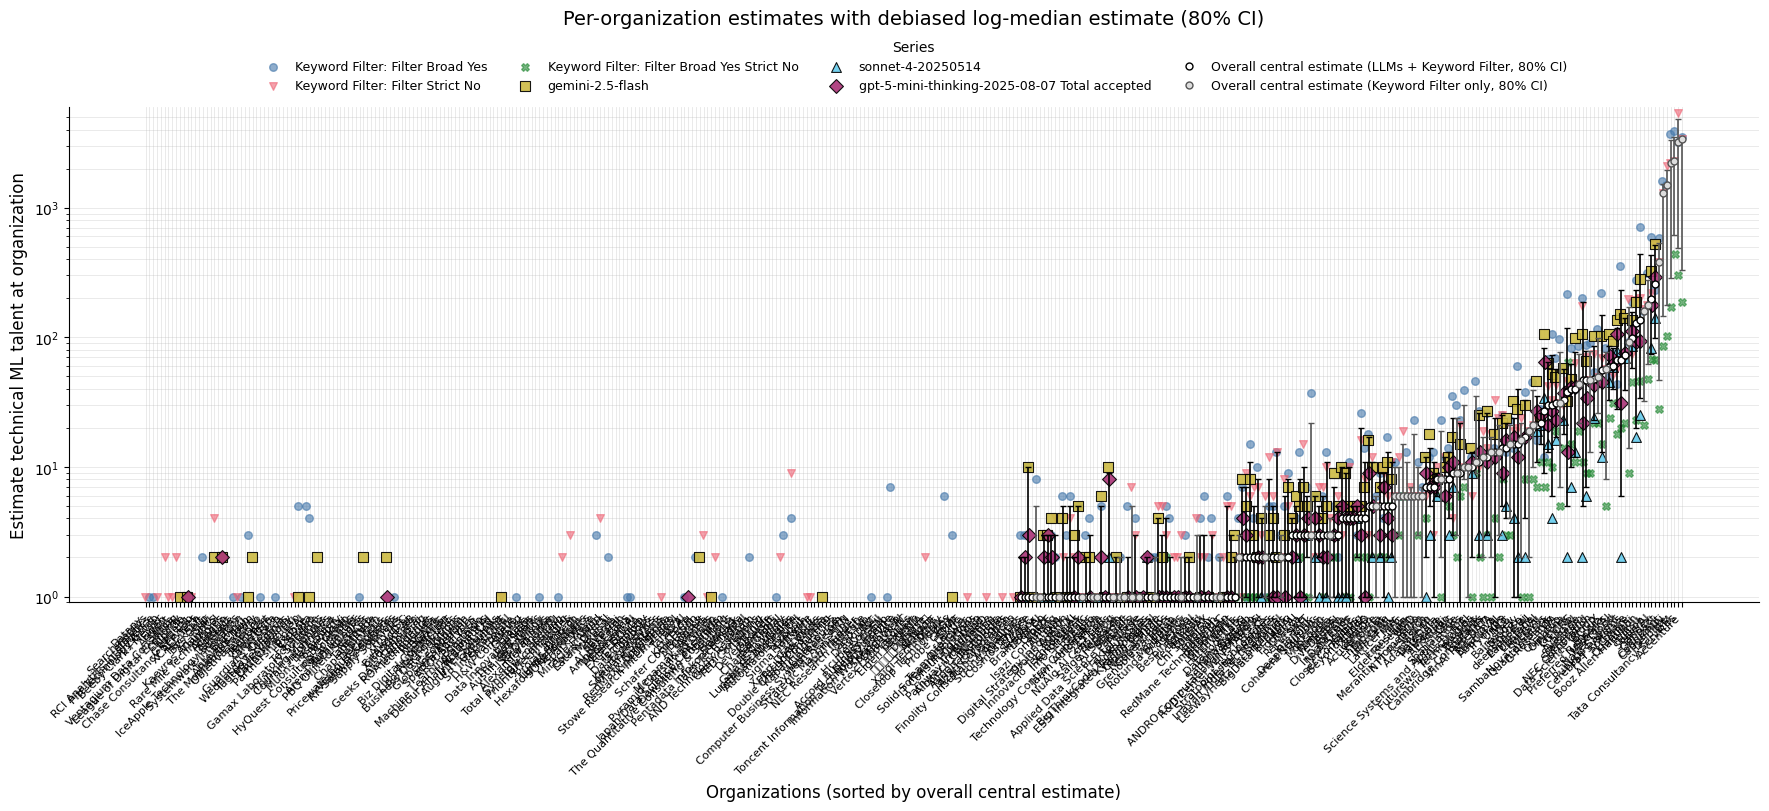

In [ ]:
# Colab-ready plotting script with full-width display and top legend
# Usage:
#   processed = main("orgs_talent_dense.tsv", y_scale="log")   # default
#   processed = main("orgs_talent_dense.tsv", y_scale="linear")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Make figures scale to 100% of the output cell width in Colab/Jupyter
try:
    from IPython.display import display, HTML
    display(HTML("""
    <style>
    /* Make matplotlib figures responsive in Colab/Jupyter */
    div.output_subarea img, div.output_subarea svg {
        width: 100% !important;
        height: auto !important;
    }
    </style>
    """))
except Exception:
    pass

# Colorblind-safe Tol "bright" palette
TOL_BRIGHT = [
    "#4477AA", "#EE6677", "#228833",
    "#CCBB44", "#66CCEE", "#AA3377", "#BBBBBB"
]

# Columns to coerce to numeric (as requested)
MAYBE_NUMERIC = [
    'filter_broad_yes', 'filter_strict_no',
    'filter_broad_yes_strict_no', 'claude_total_accepted',
    'gpt5_total_accepted', 'gemini_total_accepted',
    'ml_consensus_round', 'ml_lower80_round', 'ml_upper80_round'
]

# Custom legend labels for LLMs
LLM_LABELS = {
    'gemini_total_accepted': 'gemini-2.5-flash',
    'claude_total_accepted': 'sonnet-4-20250514',
    'gpt5_total_accepted': 'gpt-5-mini-thinking-2025-08-07 Total accepted',
}

def _read_table(file_path: str) -> pd.DataFrame:
    lower = file_path.lower()
    if lower.endswith(".tsv") or lower.endswith(".tab"):
        return pd.read_csv(file_path, sep="\t")
    if lower.endswith(".csv"):
        return pd.read_csv(file_path)
    return pd.read_csv(file_path, sep=None, engine="python")

def load_and_filter_data(file_path: str, headcount_threshold: int = 1000) -> pd.DataFrame:
    df = _read_table(file_path)
    df = df.replace(['#N/A', '#ERROR!', ''], np.nan)

    # Coerce specified columns to numeric
    for col in MAYBE_NUMERIC:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Optional headcount filter if available
    if 'Total Headcount' in df.columns:
        df['Total Headcount'] = pd.to_numeric(df['Total Headcount'], errors='coerce')
        before = len(df)
        df = df[df['Total Headcount'] <= headcount_threshold].copy()
        print(f"Loaded {before} rows. After filtering (Total Headcount <= {headcount_threshold}): {len(df)} rows.")
    else:
        print(f"Loaded {len(df)} rows. No Total Headcount column, skipping headcount filter.")

    # Ensure consensus columns exist
    required = ['ml_consensus_round', 'ml_lower80_round', 'ml_upper80_round']
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(f"Missing consensus columns: {missing}")

    return df

def create_visualization(
    df: pd.DataFrame,
    y_scale: str = "log",
    org_col_candidates = ("Organization Name", "organization", "org", "Company", "company")
):
    # Series to plot
    filter_cols = [c for c in ['filter_broad_yes','filter_strict_no','filter_broad_yes_strict_no'] if c in df.columns]
    # Order LLMs as requested in the legend: gemini, sonnet(claude), gpt-5-mini...
    llm_cols_pref = ['gemini_total_accepted','claude_total_accepted','gpt5_total_accepted']
    llm_cols = [c for c in llm_cols_pref if c in df.columns]

    # Sort by overall central estimate
    df_valid = df.dropna(subset=['ml_consensus_round']).copy()
    df_valid = df_valid.sort_values('ml_consensus_round').reset_index(drop=True)

    # Organization label column
    org_col = next((c for c in org_col_candidates if c in df_valid.columns), None)

    # A wide base size, will expand to full width via CSS above
    fig, ax = plt.subplots(figsize=(18, 9))

    x = np.arange(len(df_valid))

    # Assign colors and markers
    filter_colors  = TOL_BRIGHT[:len(filter_cols)]
    filter_markers = ['o','v','X']  # circle, down-triangle, filled X

    llm_colors  = TOL_BRIGHT[3:3+len(llm_cols)]
    llm_markers = ['s','^','D']     # square, up-triangle, diamond

    offset_step = 0.08
    handles = []
    labels  = []

    # Helper for log masks
    def _mask_vals(y):
        if y_scale == "log":
            return (~np.isnan(y)) & (y > 0)
        return ~np.isnan(y)

    # Plot keyword filters
    for i, col in enumerate(filter_cols):
        y = df_valid[col].values
        mask = _mask_vals(y)
        x_pos = x + (i - len(filter_cols)/2) * offset_step
        sc = ax.scatter(
            x_pos[mask], y[mask],
            s=30, marker=filter_markers[i % len(filter_markers)],
            c=filter_colors[i], alpha=0.6,
            label=f"Keyword Filter: {col.replace('_',' ').title()}"
        )
        handles.append(sc)
        labels.append(f"Keyword Filter: {col.replace('_',' ').title()}")

    # Plot LLMs with distinct forms and custom labels
    for j, col in enumerate(llm_cols):
        y = df_valid[col].values
        mask = _mask_vals(y)
        x_pos = x + (j - len(llm_cols)/2) * offset_step
        sc = ax.scatter(
            x_pos[mask], y[mask],
            s=50, marker=llm_markers[j % len(llm_markers)],
            facecolors=llm_colors[j], edgecolors="black",
            linewidths=0.8, alpha=0.9,
            label=LLM_LABELS.get(col, col)
        )
        handles.append(sc)
        labels.append(LLM_LABELS.get(col, col))

    # Overall central estimate (ML + Keyword Filter) with 80% CI
    c = df_valid['ml_consensus_round'].values
    l = df_valid['ml_lower80_round'].values
    u = df_valid['ml_upper80_round'].values

    # Compute epsilon for log-scale clipping
    all_pos_candidates = []
    for col in filter_cols + llm_cols + ['ml_consensus_round','ml_lower80_round','ml_upper80_round']:
        if col in df_valid.columns:
            all_pos_candidates.extend(df_valid[col][df_valid[col] > 0].tolist())
    eps = (np.nanmin(all_pos_candidates) * 0.5) if (y_scale == "log" and len(all_pos_candidates) > 0) else 1e-9

    lower_bound = np.where(np.isfinite(l), np.maximum(l, eps), np.nan)
    upper_bound = np.where(np.isfinite(u), u, np.nan)
    upper_bound = np.maximum(upper_bound, c)  # guard against anomalies

    yerr_lower_all = np.clip(c - lower_bound, a_min=0, a_max=None)
    yerr_upper_all = np.clip(upper_bound - c, a_min=0, a_max=None)

    # Determine which orgs have any LLM value present (NaN means absent; zero counts as present)
    if llm_cols:
        llm_present = np.any(df_valid[llm_cols].notna().values, axis=1)
    else:
        llm_present = np.zeros(len(df_valid), dtype=bool)

    # Mask consensus for plotting, respecting y_scale
    mask_c = np.isfinite(c)
    if y_scale == "log":
        mask_c &= (c > 0)

    # Split into two groups: with LLMs vs filter-only
    mask_with_llm = mask_c & llm_present
    mask_filter_only = mask_c & (~llm_present)

    # Plot consensus where LLMs are present (white marker, black errorbars)
    if np.any(mask_with_llm):
        err_llm = ax.errorbar(
            x[mask_with_llm], c[mask_with_llm],
            yerr=np.vstack([yerr_lower_all[mask_with_llm], yerr_upper_all[mask_with_llm]]),
            fmt='o', mfc='white', mec='black', mew=1.0, ms=5,
            ecolor='black', elinewidth=1.2, capsize=2.5, capthick=1.2,
            label='Overall central estimate (LLMs + Keyword Filter, 80% CI)',
            zorder=3
        )
        handles.append(err_llm.lines[0])
        labels.append('Overall central estimate (LLMs + Keyword Filter, 80% CI)')

    # Plot consensus where ONLY filters are present (gray marker, gray errorbars)
    if np.any(mask_filter_only):
        err_filter = ax.errorbar(
            x[mask_filter_only], c[mask_filter_only],
            yerr=np.vstack([yerr_lower_all[mask_filter_only], yerr_upper_all[mask_filter_only]]),
            fmt='o', mfc='#DDDDDD', mec='#555555', mew=1.0, ms=5,
            ecolor='#555555', elinewidth=1.2, capsize=2.5, capthick=1.2,
            label='Overall central estimate (Keyword Filter only, 80% CI)',
            zorder=3
        )
        handles.append(err_filter.lines[0])
        labels.append('Overall central estimate (Keyword Filter only, 80% CI)')

    # Labels and title
    ax.set_xlabel('Organizations (sorted by overall central estimate)', fontsize=12)
    ax.set_ylabel('Estimate technical ML talent at organization', fontsize=12)
    ax.set_title('Per-organization estimates with debiased log-median estimate (80% CI)', fontsize=14, pad=60)

    # Y scale and limits
    if y_scale not in ("linear", "log"):
        raise ValueError("y_scale must be 'linear' or 'log'")

    all_vals = []
    for col in filter_cols + llm_cols + ['ml_consensus_round','ml_lower80_round','ml_upper80_round']:
        if col in df_valid.columns:
            all_vals.extend(df_valid[col].dropna().tolist())

    if all_vals:
        if y_scale == "log":
            pos_vals = [v for v in all_vals if v > 0]
            if len(pos_vals) == 0:
                raise ValueError("No positive values available for a log-scale y-axis.")
            ymin = min(pos_vals) * 0.9
            ymax = max(pos_vals) * 1.1
            ax.set_yscale('log')
            ax.set_ylim(ymin, ymax)
        else:
            ax.set_ylim(0, max(all_vals) * 1.05)

    # Company names along the bottom, rotated for readability
    if org_col is not None:
        labels_bottom = df_valid[org_col].astype(str).tolist()
        ax.set_xticks(x)
        ax.set_xticklabels(labels_bottom, rotation=45, ha='right', fontsize=8)
        bottom_margin = 0.25
    else:
        ax.set_xticks(x)
        ax.set_xticklabels([f"Org {i}" for i in x], rotation=45, ha='right', fontsize=8)
        bottom_margin = 0.25

    # Single combined legend at top
    ncol = min(len(labels), 4) if len(labels) > 0 else 1
    ax.legend(
        handles, labels,
        loc='lower center',
        bbox_to_anchor=(0.5, 1.02),
        ncol=ncol,
        fontsize=9,
        title='Series',
        title_fontsize=10,
        frameon=False,
        borderaxespad=0.0
    )

    # Layout tuned for top legend and long x labels
    plt.tight_layout()
    plt.subplots_adjust(top=0.80, bottom=bottom_margin, right=0.98)

    # Grid and spines
    ax.grid(True, which='both', alpha=0.3, linestyle='-', linewidth=0.6)
    ax.set_axisbelow(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    return fig, ax, df_valid

def print_summary_statistics(df: pd.DataFrame):
    s = df['ml_consensus_round'].dropna()
    print("\n================ SUMMARY ================\n")
    if s.empty:
        print("No overall central estimate values found.")
        return
    print(f"Overall central estimate mean:   {s.mean():.3f}")
    print(f"Overall central estimate median: {s.median():.3f}")
    print(f"Overall central estimate std:    {s.std():.3f}")
    print(f"Overall central estimate min:    {s.min():.3f}")
    print(f"Overall central estimate max:    {s.max():.3f}")

    ai_cols = [c for c in ['gemini_total_accepted','claude_total_accepted','gpt5_total_accepted'] if c in df.columns]
    has_ai = sum(any(pd.notna(row.get(c, np.nan)) for c in ai_cols) for _, row in df.iterrows())
    print(f"\nOrganizations with any LLM estimate present: {has_ai} of {len(df)}")

def main(file_path: str = "orgs_talent_dense.tsv", y_scale: str = "log"):
    df = load_and_filter_data(file_path, headcount_threshold=1000000)
    fig, ax, df_proc = create_visualization(df, y_scale=y_scale)
    print_summary_statistics(df_proc)

    suffix = f"_{y_scale}"
    out_path = f"debiased_log_median_visualization{suffix}.png"
    fig.savefig(out_path, dpi=300, bbox_inches='tight')
    print(f"\nSaved figure to: {out_path}")

    plt.show()
    return df_proc

# Example run
if __name__ == "__main__":
    processed = main("all_orgs_debiased.tsv", y_scale="log")


In [ ]:
# === ML Talent Landscape v4: no lost points, exclusive backgrounds, x to 45% ===
USE_ADJUSTTEXT = True
if USE_ADJUSTTEXT:
    try:
        from adjustText import adjust_text
    except Exception:
        !pip -q install adjustText
        from adjustText import adjust_text

import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch, Rectangle
from matplotlib.lines import Line2D

DATA_PATH = "all_orgs_debiased.tsv"  # upload if missing

# ---- Load ----
if not os.path.exists(DATA_PATH):
    from google.colab import files  # type: ignore
    DATA_PATH = list(files.upload().keys())[0]
df = pd.read_csv(DATA_PATH, sep="\t", engine="python")

# ---- Helpers ----
def find_col(df, name_like):
    tgt = re.sub(r"[^a-z0-9]", "", str(name_like).lower())
    for c in df.columns:
        c2 = re.sub(r"[^a-z0-9]", "", str(c).lower())
        if c2 == tgt: return c
    for c in df.columns:
        c2 = re.sub(r"[^a-z0-9]", "", str(c).lower())
        if tgt in c2: return c
    return None

def parse_employee_range(val):
    if pd.isna(val): return np.nan
    s = str(val).strip().replace(",","").replace("–","-").replace("—","-").replace("−","-")
    m = re.match(r"^\s*(\d+)\s*-\s*(\d+)\s*$", s)
    if m:
        a, b = int(m.group(1)), int(m.group(2)); return (a+b)/2.0
    m = re.match(r"^\s*(\d+)\s*(?:to|-)\s*(\d+)\s*$", s)
    if m:
        a, b = int(m.group(1)), int(m.group(2)); return (a+b)/2.0
    m = re.match(r"^\s*(\d+)\s*\+\s*$", s)
    if m: return float(m.group(1))
    m = re.match(r"^\s*(\d+)\s*$", s)
    if m: return float(m.group(1))
    return np.nan

# ---- Columns ----
ORG_COL = find_col(df, "organization_name") or df.columns[0]
ML_COUNT_COL = find_col(df, "ml_consensus_round") or find_col(df, "ml_count") or find_col(df, "ml")
STAGE_COL = find_col(df, "stage_reached") or find_col(df, "Stage Reached")

# Robust employees: combine multiple sources row-wise (first non-null)
emp_sources = []
for cand in ["number_of_employees_numeric", "total_headcount", "employees_numeric", "employee_count"]:
    col = find_col(df, cand)
    if col is not None:
        emp_sources.append(pd.to_numeric(df[col], errors="coerce"))
raw_col = find_col(df, "number_of_employees")
if raw_col is not None:
    emp_sources.append(df[raw_col].apply(parse_employee_range))

emp = emp_sources[0].copy() if emp_sources else pd.Series(np.nan, index=df.index, dtype=float)
for s in emp_sources[1:]:
    emp = emp.fillna(s)

ml_n = pd.to_numeric(df[ML_COUNT_COL], errors="coerce")
stage = df[STAGE_COL].astype(str) if STAGE_COL else ""

plot = pd.DataFrame({"org": df[ORG_COL].astype(str), "ml_n": ml_n, "emp": emp, "stage": stage})
plot["ml_pct"] = (plot["ml_n"] / plot["emp"]) * 100.0
plot["ml_pct"] = plot["ml_pct"].clip(lower=0, upper=100)  # keep everything visible; cap at 100%

plot = plot.replace([np.inf, -np.inf], np.nan).dropna(subset=["ml_n","emp","ml_pct"])
plot = plot[(plot["ml_n"] > 0) & (plot["emp"] > 0)]

def any_work_trial(series):
    s = series.dropna().astype(str).str.strip()
    s = s.str.replace("–","-").str.replace("—","-").str.replace("\u2212","-").str.lower()
    return s.str.contains(r"^5\s*-\s*work\s*trial$").any()

agg = (plot.groupby("org", as_index=False)
             .agg(ml_n=("ml_n","median"),
                  emp=("emp","median"),
                  ml_pct=("ml_pct","median"),
                  work_trial=("stage", any_work_trial)))

def assign_cluster(n, pct):
    if (n >= 500) and (pct >= 0.5): return "Giant"
    if (n >= 50)  and (pct >= 1.0): return "Powerhouse"
    if (n >= 10)  and (pct >= 5.0): return "Emerging"
    return "Other"
agg["cluster"] = [assign_cluster(n, p) for n, p in agg[["ml_n","ml_pct"]].to_numpy()]

palette = {"Giant":"#9467BD", "Powerhouse":"#1F77B4", "Emerging":"#2CA02C", "Other":"#BDBDBD"}
markers = {"Giant":"D", "Powerhouse":"s", "Emerging":"^", "Other":"o"}

# ---- Plot ----
fig, ax = plt.subplots(figsize=(12, 7.9))
ax.set_xlim(0, 45)
ax.set_yscale("log")

# points (work trial -> black border)
for lab, sub in agg.groupby("cluster"):
    edge = np.where(sub["work_trial"], "black", "none")
    lw = np.where(sub["work_trial"], 1.2, 0.0)
    ax.scatter(sub["ml_pct"], sub["ml_n"], s=64, c=palette.get(lab, "#BDBDBD"),
               marker=markers.get(lab, "o"), alpha=0.95, edgecolors=edge, linewidths=lw, zorder=2)

ax.relim(); ax.autoscale(axis='y')
ymin, ymax = ax.get_ylim()

# exclusive faint backgrounds
def add_band(x0, y0, x1, y1, color, z=0):
    if y1 > y0 and x1 > x0:
        ax.add_patch(Rectangle((x0, y0), x1 - x0, y1 - y0,
                               facecolor=color, alpha=0.08, edgecolor="none", zorder=z))

add_band(5.0, 10, 45.0, min(50, ymax), palette["Emerging"], z=0)     # Emerging only
add_band(1.0, 50, 45.0, min(500, ymax), palette["Powerhouse"], z=0.1)# Powerhouse only
add_band(0.5, 500, 45.0, ymax,          palette["Giant"], z=0.2)     # Giant only

# threshold lines
ax.axhline(10,  linestyle="-.", color="0.45", linewidth=1.2, zorder=1)
ax.axhline(50,  linestyle="--", color="0.45", linewidth=1.2, zorder=1)
ax.axhline(500, linestyle=":",  color="0.45", linewidth=1.2, zorder=1)
ax.axvline(5.0, linestyle="-.", color="0.45", linewidth=1.2, zorder=1)
ax.axvline(1.0, linestyle="--", color="0.45", linewidth=1.2, zorder=1)
ax.axvline(0.5, linestyle=":",  color="0.45", linewidth=1.2, zorder=1)

# labels
ax.set_xlabel("ML share (% of organization)")
ax.set_ylabel("ML staff Estimate (debiased log-median)")
ax.set_title("ML Talent Landscape — Enterprise / Mid-Scale / Boutique")
ax.grid(axis="y", which="both", alpha=0.15)

# annotate all Giant/Powerhouse/Emerging orgs
texts = [ax.text(r["ml_pct"], r["ml_n"], r["org"], fontsize=8, ha="left", va="bottom")
         for _, r in agg[agg["cluster"].isin(["Giant","Powerhouse","Emerging"])].iterrows()]
if USE_ADJUSTTEXT and len(texts) > 0:
    adjust_text(texts, ax=ax, expand_text=(1.02,1.08), expand_points=(1.02,1.08),
                arrowprops=dict(arrowstyle="-", lw=0.5, color="0.5"))

# legend (threshold descriptions + work trial border)
handles = [
    Patch(facecolor=palette["Giant"], alpha=0.20, edgecolor="none", label="Enterprise (≥500 ML & 0.5%"),
    Patch(facecolor=palette["Powerhouse"], alpha=0.20, edgecolor="none", label="Mid-Scale (≥50 ML & 1%"),
    Patch(facecolor=palette["Emerging"], alpha=0.20, edgecolor="none", label="Boutique: (≥10 ML & 5%"),
    Line2D([0],[0], marker='o', color='w', label='Work Trial : Black border',
           markerfacecolor="#BDBDBD", markeredgecolor="black", markersize=8, linewidth=0)
]
ax.legend(handles=handles, loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=True)
plt.subplots_adjust(right=0.78)

plt.savefig("ml_talent_landscape_custom.png", dpi=200, bbox_inches="tight")
plt.show()

print("Counts by cluster:\n", agg["cluster"].value_counts())
print("Work Trial orgs:", int(agg["work_trial"].sum()))


In [ ]:
# === ML Talent Landscape v4: no lost points, exclusive backgrounds, x to 45% ===
USE_ADJUSTTEXT = True
if USE_ADJUSTTEXT:
    try:
        from adjustText import adjust_text
    except Exception:
        !pip -q install adjustText
        from adjustText import adjust_text

import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch, Rectangle

DATA_PATH = "all_orgs_debiased.tsv"  # upload if missing

# ---- Load ----
if not os.path.exists(DATA_PATH):
    from google.colab import files  # type: ignore
    DATA_PATH = list(files.upload().keys())[0]
df = pd.read_csv(DATA_PATH, sep="\t", engine="python")

# ---- Helpers ----
def find_col(df, name_like):
    tgt = re.sub(r"[^a-z0-9]", "", str(name_like).lower())
    for c in df.columns:
        c2 = re.sub(r"[^a-z0-9]", "", str(c).lower())
        if c2 == tgt: return c
    for c in df.columns:
        c2 = re.sub(r"[^a-z0-9]", "", str(c).lower())
        if tgt in c2: return c
    return None

def parse_employee_range(val):
    if pd.isna(val): return np.nan
    s = str(val).strip().replace(",","").replace("–","-").replace("—","-").replace("−","-")
    m = re.match(r"^\s*(\d+)\s*-\s*(\d+)\s*$", s)
    if m:
        a, b = int(m.group(1)), int(m.group(2)); return (a+b)/2.0
    m = re.match(r"^\s*(\d+)\s*(?:to|-)\s*(\d+)\s*$", s)
    if m:
        a, b = int(m.group(1)), int(m.group(2)); return (a+b)/2.0
    m = re.match(r"^\s*(\d+)\s*\+\s*$", s)
    if m: return float(m.group(1))
    m = re.match(r"^\s*(\d+)\s*$", s)
    if m: return float(m.group(1))
    return np.nan

# ---- Columns ----
ORG_COL = find_col(df, "organization_name") or df.columns[0]
ML_COUNT_COL = find_col(df, "ml_consensus_round") or find_col(df, "ml_count") or find_col(df, "ml")
STAGE_COL = find_col(df, "stage_reached") or find_col(df, "Stage Reached")

# Robust employees: combine multiple sources row-wise (first non-null)
emp_sources = []
for cand in ["number_of_employees_numeric", "total_headcount", "employees_numeric", "employee_count"]:
    col = find_col(df, cand)
    if col is not None:
        emp_sources.append(pd.to_numeric(df[col], errors="coerce"))
raw_col = find_col(df, "number_of_employees")
if raw_col is not None:
    emp_sources.append(df[raw_col].apply(parse_employee_range))

emp = emp_sources[0].copy() if emp_sources else pd.Series(np.nan, index=df.index, dtype=float)
for s in emp_sources[1:]:
    emp = emp.fillna(s)

ml_n = pd.to_numeric(df[ML_COUNT_COL], errors="coerce")
stage = df[STAGE_COL].astype(str) if STAGE_COL else ""

plot = pd.DataFrame({"org": df[ORG_COL].astype(str), "ml_n": ml_n, "emp": emp, "stage": stage})
plot["ml_pct"] = (plot["ml_n"] / plot["emp"]) * 100.0
plot["ml_pct"] = plot["ml_pct"].clip(lower=0, upper=100)  # keep everything visible; cap at 100%

plot = plot.replace([np.inf, -np.inf], np.nan).dropna(subset=["ml_n","emp","ml_pct"])
plot = plot[(plot["ml_n"] > 0) & (plot["emp"] > 0)]

agg = (plot.groupby("org", as_index=False)
             .agg(ml_n=("ml_n","median"),
                  emp=("emp","median"),
                  ml_pct=("ml_pct","median")))

def assign_cluster(n, pct):
    if (n >= 500) and (pct >= 0.5): return "Giant"
    if (n >= 50)  and (pct >= 1.0): return "Powerhouse"
    if (n >= 10)  and (pct >= 5.0): return "Emerging"
    return "Other"
agg["cluster"] = [assign_cluster(n, p) for n, p in agg[["ml_n","ml_pct"]].to_numpy()]

palette = {"Giant":"#9467BD", "Powerhouse":"#1F77B4", "Emerging":"#2CA02C", "Other":"#BDBDBD"}
markers = {"Giant":"D", "Powerhouse":"s", "Emerging":"^", "Other":"o"}

# ---- Plot ----
fig, ax = plt.subplots(figsize=(12, 7.9))
ax.set_xlim(0, 45)
ax.set_yscale("log")

# points
for lab, sub in agg.groupby("cluster"):
    ax.scatter(sub["ml_pct"], sub["ml_n"], s=64, c=palette.get(lab, "#BDBDBD"),
               marker=markers.get(lab, "o"), alpha=0.95, zorder=2)

ax.relim(); ax.autoscale(axis='y')
ymin, ymax = ax.get_ylim()

# exclusive faint backgrounds
def add_band(x0, y0, x1, y1, color, z=0):
    if y1 > y0 and x1 > x0:
        ax.add_patch(Rectangle((x0, y0), x1 - x0, y1 - y0,
                               facecolor=color, alpha=0.08, edgecolor="none", zorder=z))

add_band(5.0, 10, 45.0, min(50, ymax), palette["Emerging"], z=0)     # Emerging only
add_band(1.0, 50, 45.0, min(500, ymax), palette["Powerhouse"], z=0.1)# Powerhouse only
add_band(0.5, 500, 45.0, ymax,          palette["Giant"], z=0.2)     # Giant only

# threshold lines
ax.axhline(10,  linestyle="-.", color="0.45", linewidth=1.2, zorder=1)
ax.axhline(50,  linestyle="--", color="0.45", linewidth=1.2, zorder=1)
ax.axhline(500, linestyle=":",  color="0.45", linewidth=1.2, zorder=1)
ax.axvline(5.0, linestyle="-.", color="0.45", linewidth=1.2, zorder=1)
ax.axvline(1.0, linestyle="--", color="0.45", linewidth=1.2, zorder=1)
ax.axvline(0.5, linestyle=":",  color="0.45", linewidth=1.2, zorder=1)

# labels
ax.set_xlabel("ML share (% of organization)")
ax.set_ylabel("ML staff Estimate (debiased log-median)")
ax.set_title("ML Talent Landscape — Enterprise / Mid-Scale / Boutique")
ax.grid(axis="y", which="both", alpha=0.15)

# annotate all Giant/Powerhouse/Emerging orgs
texts = [ax.text(r["ml_pct"], r["ml_n"], r["org"], fontsize=8, ha="left", va="bottom")
         for _, r in agg[agg["cluster"].isin(["Giant","Powerhouse","Emerging"])].iterrows()]
if USE_ADJUSTTEXT and len(texts) > 0:
    adjust_text(texts, ax=ax, expand_text=(1.02,1.08), expand_points=(1.02,1.08),
                arrowprops=dict(arrowstyle="-", lw=0.5, color="0.5"))

# legend (threshold descriptions)
handles = [
    Patch(facecolor=palette["Giant"], alpha=0.20, edgecolor="none", label="Enterprise (≥500 ML & 0.5%"),
    Patch(facecolor=palette["Powerhouse"], alpha=0.20, edgecolor="none", label="Mid-Scale (≥50 ML & 1%"),
    Patch(facecolor=palette["Emerging"], alpha=0.20, edgecolor="none", label="Boutique: (≥10 ML & 5%")
]
ax.legend(handles=handles, loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=True)
plt.subplots_adjust(right=0.78)

plt.savefig("ml_talent_landscape_custom.png", dpi=200, bbox_inches="tight")
plt.savefig("ml_talent_landscape_custom.pdf", bbox_inches="tight")
plt.savefig("ml_talent_landscape_custom.svg", bbox_inches="tight")
plt.savefig("ml_talent_landscape_custom.eps", bbox_inches="tight")
plt.show()

print("Counts by cluster:\n", agg["cluster"].value_counts())

In [ ]:
# Colab cell: build_organizations_list_v3.py
# Input: one TSV file with the columns named below
# Output: organizations_list.csv with the requested columns and formatting

import pandas as pd
import numpy as np
import re
from pathlib import Path

# ----------------------------
# User input: set your file path here
FILE = "all_orgs_debiased.tsv"  # replace with your uploaded TSV
# ----------------------------

# Order for the Individual estimates array (six items)
INDIVIDUAL_METHODS = [
    "filter_broad_yes_strict_no",
    "filter_strict_no",
    "filter_broad_yes",
    "claude_total_accepted",
    "gpt5_total_accepted",
    "gemini_total_accepted",
]

# Required columns overall
REQUIRED = [
    "Organization Name",
    "Country",
    "Stage Reached",
    "category",
    "Total Headcount",
    "Founded Date",
    "ml_share",
    "ml_share_lower80",
    "ml_share_upper80"
] + INDIVIDUAL_METHODS

# ----------------------------
# Helpers
# ----------------------------

def to_numeric_series_clean(series):
    """Vectorized numeric coercion for numeric columns by stripping commas/spaces."""
    if series.dtype.kind in ("i", "u", "f"):
        return pd.to_numeric(series, errors="coerce")
    s = series.astype(str).str.replace(r"[,\s]", "", regex=True)
    return pd.to_numeric(s, errors="coerce")

def extract_year_only(series):
    """
    Return an Int64 series with just the year:
    - First try pandas datetime year
    - Fallback to the first 4-digit year in [1700, 2100]
    """
    dt = pd.to_datetime(series, errors="coerce", infer_datetime_format=True)
    years = dt.dt.year

    need_fallback = years.isna()
    if need_fallback.any():
        s = series.astype(str)
        # find first 4-digit token
        def find_year(x):
            m = re.search(r"(\d{4})", x)
            if not m:
                return np.nan
            y = int(m.group(1))
            return y if 1700 <= y <= 2100 else np.nan
        years_fb = s.map(find_year)
        years = years.fillna(years_fb)

    return years.astype("Int64")

def format_int_iso(n):
    """Format integers with spaces between groups of three digits."""
    if n is None or (isinstance(n, float) and not np.isfinite(n)) or pd.isna(n):
        return None
    n = int(n)
    sign = "-" if n < 0 else ""
    s = str(abs(n))
    groups = []
    while s:
        groups.append(s[-3:])
        s = s[:-3]
    return sign + " ".join(reversed(groups))

def interval_str(c, l, u):
    """Return 'C (L - U)' using ISO-spaced integers, '-' if all missing."""
    if pd.isna(c) and pd.isna(l) and pd.isna(u):
        return "-"
    def s(x):
        return format_int_iso(x) if not pd.isna(x) else None
    c_s, l_s, u_s = s(c), s(l), s(u)
    if c_s is None and l_s is None and u_s is None:
        return "-"
    if l_s and u_s:
        return f"{c_s or '-'} ({l_s} - {u_s})"
    if l_s:
        return f"{c_s or '-'} ({l_s})"
    if u_s:
        return f"{c_s or '-'} ({u_s})"
    return f"{c_s}"

def pct_str(numer, denom, decimals=1):
    """Format percentage with one decimal; return '-' if denom is missing/zero."""
    if denom is None or not np.isfinite(denom) or denom <= 0:
        return "-"
    if numer is None or not np.isfinite(numer):
        return "-"
    pct = 100.0 * float(numer) / float(denom)
    return f"{pct:.{decimals}f} %"

def _share_to_fraction(value):
    """
    Convert a share that may be given either as a fraction (0..1) or a percent (>1)
    into a fraction in [0,1]. Returns None if missing or non-numeric.
    """
    x = to_numeric_scalar(value)
    if x is None or not np.isfinite(x):
        return None
    x = float(x)
    return x / 100.0 if x > 1.0 else x

def rate_org_row(r):
    """
    Return one of:
      'Enterprise ML Consultancies'
      'Mid-Scale ML Consultancies'
      'Boutique ML Consultancies'
      '-'
    using ml_consensus_round for staff count and ml_share for percent.
    Precedence: Enterprise > Mid-Scale > Boutique.
    Thresholds:
      Enterprise:  ML staff ≥ 500  AND  ml_share > 0.5%
      Mid-Scale:   ML staff ≥ 50   AND  ml_share > 1%
      Boutique:    ML staff ≥ 10   AND  ml_share > 5%
    """
    ml_staff = to_numeric_scalar(r.get("ml_consensus_round"))
    share = _share_to_fraction(r.get("ml_share"))  # strictly from ml_share as requested
    if ml_staff is None or share is None:
        return "-"
    # Highest tier first
    if ml_staff >= 500 and share >= 0.005:
        return "Enterprise ML Consultancies"
    if ml_staff >= 50 and share >= 0.01:
        return "Mid-Scale ML Consultancies"
    if ml_staff >= 10 and share >= 0.05 and ml_staff < 50 :
        return "Boutique ML Consultancies"
    return "-"


def pct_from_fraction(frac, decimals=1):
    """Format a fraction (e.g., 0.123) as a percent string."""
    if frac is None or not np.isfinite(frac):
        return "-"
    return f"{100.0 * float(frac):.{decimals}f} %"

def percent_with_interval_row(r, decimals=1):
    """
    Build 'x.y % (l.y % - u.y %)' for a single organization.
    Central value defaults to ml_consensus_round / Total Headcount.
    If headcount is missing/zero, fall back to ml_share when present.
    The interval comes from ml_share_lower80 and ml_share_upper80.
    Values may be given as fractions in [0,1] or percents (>1); both are handled.
    """
    # Central percent from counts
    def _to_num(x):
        return to_numeric_scalar(x)

    numer = _to_num(r.get("ml_consensus_round"))
    denom = _to_num(r.get("Total Headcount"))
    base = pct_str(numer, denom, decimals=decimals)  # '-' if denom missing/zero

    # Shares for interval (and optional central fallback)
    def _norm_frac(x):
        if x is None or not np.isfinite(x):
            return None
        x = float(x)
        return x / 100.0 if x > 1.0 else x  # interpret >1 as percent

    l = _norm_frac(_to_num(r.get("ml_share_lower80"))) if "ml_share_lower80" in r else None
    u = _norm_frac(_to_num(r.get("ml_share_upper80"))) if "ml_share_upper80" in r else None
    c = _norm_frac(_to_num(r.get("ml_share")))          if "ml_share" in r else None

    # If base is unavailable but we have a central share, use it
    if base == "-" and c is not None:
        base = pct_from_fraction(c, decimals=decimals)

    # Assemble interval string
    l_s = pct_from_fraction(l, decimals=decimals) if l is not None else None
    u_s = pct_from_fraction(u, decimals=decimals) if u is not None else None

    if l_s and u_s:
        return f"{base} ({l_s} - {u_s})" if base != "-" else f"{pct_from_fraction(c, decimals)} ({l_s} - {u_s})" if c is not None else f"- ({l_s} - {u_s})"
    if l_s:
        return f"{base} ({l_s})" if base != "-" else f"{pct_from_fraction(c, decimals)} ({l_s})" if c is not None else f"- ({l_s})"
    if u_s:
        return f"{base} ({u_s})" if base != "-" else f"{pct_from_fraction(c, decimals)} ({u_s})" if c is not None else f"- ({u_s})"
    return base


def to_numeric_scalar(value):
    """Best-effort scalar coercion to number; booleans -> 1/0; None/empty -> None."""
    if value is None or (isinstance(value, float) and np.isnan(value)):
        return None
    s = str(value).strip()
    if s == "":
        return None
    low = s.lower()
    if low in {"true","t","yes","y"}:
        return 1
    if low in {"false","f","no","n"}:
        return 0
    s2 = s.replace(",", "").replace(" ", "")
    try:
        x = float(s2)
        if np.isfinite(x):
            if abs(x - int(round(x))) < 1e-9:
                return int(round(x))
            return x
    except Exception:
        pass
    # Not numeric: return None to output '-'
    return None

def array_numbers_only(values):
    """
    Build the 'Individual estimates ML Talent' array string:
    - numbers only (ints or floats), or '-' for missing
    - no quotes around elements
    - no thousands grouping inside the array
    Example: [12, -, 3, 15, 2, 0]
    """
    elems = []
    for v in values:
        num = to_numeric_scalar(v)
        if num is None:
            elems.append("-")
        elif isinstance(num, int):
            elems.append(str(num))
        else:
            # float: trim trailing .0 if integer-like
            if abs(num - int(round(num))) < 1e-9:
                elems.append(str(int(round(num))))
            else:
                elems.append(str(num))
    return "[" + ", ".join(elems) + "]"

# ----------------------------
# Load and validate
# ----------------------------
df = pd.read_csv(FILE, sep="\t", dtype=str, low_memory=False)
missing = [c for c in REQUIRED if c not in df.columns]
if missing:
    raise ValueError(f"{Path(FILE).name}: missing columns: {missing}")

# Numeric coercion for computations
df["ml_consensus_round"] = to_numeric_series_clean(df["ml_consensus_round"])
df["ml_lower80_round"]   = to_numeric_series_clean(df["ml_lower80_round"])
df["ml_upper80_round"]   = to_numeric_series_clean(df["ml_upper80_round"])
df["Total Headcount"]    = to_numeric_series_clean(df["Total Headcount"])

# Sort by median ML estimate descending (NaNs last)
df = df.sort_values("ml_consensus_round", ascending=False, na_position="last").reset_index(drop=True)

# Build pieces
company_name = df["Organization Name"].fillna("").str.strip()
founded_year = extract_year_only(df["Founded Date"])
country      = df["Country"].fillna("").str.strip()

total_staff_iso = df["Total Headcount"].apply(lambda x: format_int_iso(x) or "-")

indiv_arrays = df.apply(lambda r: array_numbers_only([r[col] for col in INDIVIDUAL_METHODS]), axis=1)

debiased = df.apply(lambda r: interval_str(r["ml_consensus_round"], r["ml_lower80_round"], r["ml_upper80_round"]), axis=1)

pct_ml = df.apply(lambda r: percent_with_interval_row(r, decimals=1), axis=1)

rating = df.apply(rate_org_row, axis=1)


stage = df["Stage Reached"].fillna("").astype(str).str.strip()
cat   = df["category"].fillna("").astype(str).str.strip()
worktrial = []
for a, b in zip(stage, cat):
    if a and b:
        worktrial.append(f"{a} - {b}")
    elif a:
        worktrial.append(a)
    elif b:
        worktrial.append(b)
    else:
        worktrial.append("-")

# Assemble final DataFrame in the specified order and names
out = pd.DataFrame({
    "Company Name": company_name.replace(r"^\s*$", "-", regex=True),
    "Founded": founded_year.map(lambda y: str(int(y)) if pd.notna(y) else "-"),
    "Country": country.replace(r"^\s*$", "-", regex=True),
    "Total Staff Count": total_staff_iso,
    "Individual estimates ML Talent (filter_broad_yes_strict_no, filter_strict_no, filter_broad_yes, claude_total_accepted, gpt5_total_accepted, gemini_total_accepted)": indiv_arrays,
    "debiased log-median ML Talent": debiased,
    "% ML of total staff count": pd.Series(pct_ml),
    "Category": pd.Series(rating),
    "Worktrial Outcome": pd.Series(worktrial),
})

# Hyphen cleanup
out = out.replace({np.nan: "-"})
out = out.replace(r"^\s*$", "-", regex=True)

# Save
out_path = Path("./organizations_list.csv")
out.to_csv(out_path, index=False)
print(f"Saved {out_path.resolve()}")

# Preview top rows
out.head(10)
